In [1]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams.update({'font.size': 16})
%matplotlib inline
import cartopy.crs as ccrs
import cartopy

from wrfProcessing import *

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.precip_model_functions import qsat
SCRATCH='/global/cscratch1/sd/qnicolas/'

import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

In [2]:
xr.set_options(display_style='text') 

# Functions, data

In [3]:
def extract_wrfout(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)
def extract_wrfpro(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfpout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)

In [4]:
hrchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/')

hrchannel_p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/')

hrchannelprecip=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.precip.days0-200.nc')

hrchannel_capecin=xr.open_mfdataset(sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.cape.*')),combine='nested',concat_dim='Time',parallel=True).cape_2d

In [5]:
hrhgt = hrchannel.HGT.isel(south_north=0,Time=-1).persist()
def plotsection(hgt,figsize=(15,4)):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    ax.set_xlabel("distance west of mountain top (km)")
    ax.set_ylabel("height(m)")
    ax.plot((1635-hgt.west_east)*3,hgt,color='k')
    return ax,ax.twinx()

def f(x):
    return np.sign(x)*x**2

def change_coords_eta(sim,w,center=1635,staggered=0):
    if staggered:
        return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3,'eta_level':sim.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level','west_east':'distance_from_mtn'}).persist()
    else:
        return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3,'eta_level':sim.ZNU.isel(Time=-1),'pressure':sim.PB[-1,:,0,:].load()/100}).swap_dims({'bottom_top':'eta_level','west_east':'distance_from_mtn'}).persist()

def change_coords_etav(sim,w,staggered=0):
    if staggered:
        return w.assign_coords({'eta_level':sim.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level'}).persist()
    else:
        return w.assign_coords({'eta_level':sim.ZNU.isel(Time=-1),'pressure':sim.PB[-1,:,0,:].load()/100}).swap_dims({'bottom_top':'eta_level'}).persist()


def change_coords_pl(sim,w,center=1635):
    return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3,'pressure':sim.P_PL[0]/100}).swap_dims({'num_press_levels_stag':'pressure','west_east':'distance_from_mtn'}).persist()

def change_coords_press(sim,w):
    return w.assign_coords({'pressure':sim.P_PL[0]/100}).swap_dims({'num_press_levels_stag':'pressure'})

def change_coords_sfc(w,center=1635):
    return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3}).swap_dims({'west_east':'distance_from_mtn'}).persist()


In [6]:
plevs=np.array([100000,97500,95000,92500,90000,87500,85000,82500,80000,77500,75000,70000,65000,60000,55000,50000,45000,40000,35000,30000,25000,22500,20000,17500,15000,12500,10000,7000,5000,1000])/100


In [7]:
umean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.U_PL.days50-200.nc')
vmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.V_PL.days50-200.nc')
wmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.W_PL.days50-200.nc')
rhomean = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.RHO_PL.days50-200.nc')
qmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.Q_PL.days50-200.nc')
tmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.T_PL.days50-200.nc')
zmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.GHT_PL.days50-100.nc')


In [9]:
umean   = umean.where(umean > -30)  
vmean   = vmean.where(vmean > -30)  
wmean   = wmean.where(wmean > -30)  
rhomean = rhomean.where(rhomean >0.)  
qmean   = qmean.where(qmean >0.)  
tmean   = tmean.where(tmean >100.)  
omegamean = -9.81*rhomean*wmean
zmean   = zmean.where(zmean >=0.)  

In [10]:
omegamean_p = change_coords_pl(hrchannel_p,omegamean)[1:-4]
tmean_p = change_coords_pl(hrchannel_p,tmean)[1:-4]
zmean_p = change_coords_pl(hrchannel_p,zmean)[1:-4]
qmean_p = change_coords_pl(hrchannel_p,qmean)[1:-4]

In [14]:
#%%time #takes 10min
#rhomean_s=hrchannel.RHO.isel(Time=slice(200,801)).mean(['Time','south_north']).persist()
#qmean_s=hrchannel.QVAPOR.isel(Time=slice(200,801)).mean(['Time','south_north']).persist()
#temp = (hrchannel.T+300)*((hrchannel.PB+hrchannel.P)/1e5)**0.286
#tmean_s = temp.isel(Time=slice(200,801)).mean(['Time','south_north'])
#tmean_s.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.TEMP.days50-200.nc')
#rhomean_s.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.RHO.days50-200.nc')
#qmean_s.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.QVAPOR.days50-200.nc')

In [11]:
wmean_s = change_coords_eta(hrchannel,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.W.days50-200.nc'),staggered=True)
wdrymean_s = change_coords_eta(hrchannel,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.W.days50-100.nc'),staggered=True)


In [15]:
tmean_s   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.TEMP.days50-200.nc')
rhomean_s = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.RHO.days50-200.nc')
qmean_s   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.QVAPOR.days50-200.nc')
tmean_s   = change_coords_eta(hrchannel,tmean_s  )
rhomean_s = change_coords_eta(hrchannel,rhomean_s)    
qmean_s   = change_coords_eta(hrchannel,qmean_s  )
    
    

In [12]:
def pressure_delta(column,pressure) :
    """given two arrays of the same length, return the pressure range corresponding to the non-nan values of column.
    e.g. if column = [nan,a,b,c,nan,nan] and pressure=[p1,p2,p3,p4,p5,p6], return p4-p2.
    Doesn't work if there are nans in the middle, eg. column = [nan,a,nan,c,nan,nan] (would still return p4-p2)"""
    
    idxs = np.where(~np.isnan(column))[0]
    try :
        return np.abs(pressure[idxs[-1]]-pressure[idxs[0]])
    except IndexError :
        print("Column only contains nans")
        return np.nan
def pressure_mean(da,vdim='pressure'):
    da_integ = da.fillna(0.).integrate(vdim)
    weights = xr.apply_ufunc(pressure_delta,da,da.pressure,input_core_dims=[[vdim],[vdim]],vectorize=True)#,dask="parallelized",output_dtypes=float)
    return da_integ/weights

In [13]:
def plot_skewt(T,q,plevs,skew,color,lbl):
    P = plevs* units.hPa
    i=0
    Tups = units.degK*np.array(T)
    qups = np.array(q)

    #P=P[::-1]
    #Tups=Tups[::-1]
    #qups=qups[::-1]

    skew.plot(P, Tups,color=color ,label=lbl + " T")
    
    Tdups = mpcalc.dewpoint_from_specific_humidity(qups,Tups,P)
    skew.plot(P, Tdups,color=color , linestyle='--',label=lbl + " Tdew")

    #first non-nan index
    maxcape = np.argmax(~np.isnan(np.array(T)))
    try:
        profups = mpcalc.parcel_profile(P[maxcape:], Tups[maxcape], Tdups[maxcape]).to('degC')
        skew.plot(P[maxcape:], profups, color=color, linestyle=':'  ,label=lbl+ " parcel profile")
        skew.shade_cape(P[maxcape:], Tups[maxcape:], profups,color=color)
        print(" CAPE = %.1f J/kg"%(mpcalc.cape_cin(P[maxcape:], Tups[maxcape:], Tdups[maxcape:],profups)[0]/units("J/kg")))
    except RuntimeError:
        print('no cape')
    
    
    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-40, 50)
    skew.ax.legend()
    skew.plot_dry_adiabats(linewidth=0.5)
    skew.plot_moist_adiabats(linewidth=0.5)
    

  

## Reference profiles

In [8]:
from scipy.integrate import cumtrapz
def A_npy(T,p):
    """T temperature in Kelvin, p in pascal. p must be increasing"""
    assert p[0]<p[1]
    L = 2.26e6
    Cp=1004.
    Rv = 461.
    gamma = L*qsat(T,p/100.)/Rv/T**2 * L/Cp
    kappa=2/7
    bl = np.where(p>95000.)[0]
    freetrop = np.where(p<=95000.)[0]
    integ = 1/(1+gamma[freetrop])*np.exp(kappa*cumtrapz(1/(1+gamma[freetrop][::-1]),np.log(p[freetrop][::-1]),initial=0))[::-1]
    a = np.concatenate([integ,integ[-1]*(p[bl]/p[freetrop][-1])**kappa])
    return  a

def A_npy2(T,p):
    idxs = np.where(~np.isnan(T))[0]
    n=len(p)
    T=T[idxs]
    p=p[idxs]
    a = A_npy(T,p)
    return np.concatenate([[np.nan]*idxs[0] ,a,[np.nan]*(n-1-idxs[-1])])
def A(T,p):
    return xr.apply_ufunc(A_npy2,T,p,input_core_dims=[['pressure'],['pressure']],output_core_dims=[['pressure']],vectorize=True)
    

def Aplus_npy(T,p):
    idxs = np.where(~np.isnan(T))[0]
    n=len(p)
    T=T[idxs]
    p=p[idxs]
    a = A_npy(T,p)
    return np.concatenate([[np.nan]*idxs[0] ,-cumtrapz(a[::-1],np.log(p[::-1]),initial=0)[::-1],[np.nan]*(n-1-idxs[-1])])

def Omega_npy(T,p):
    aplus=Aplus_npy(T,p)
    aplushat = np.trapz(aplus,p)/(p[-1]-p[0])
    return cumtrapz(aplus[::-1]-aplushat,p[::-1],initial=0)[::-1]

def Aplus(T,p):
    return xr.apply_ufunc(Aplus_npy,T,p,input_core_dims=[['pressure'],['pressure']],output_core_dims=[['pressure']],vectorize=True)
    

def Omega(T,p):
    aplus=Aplus(T,p)
    aplushat = pressure_mean(aplus)
    return xr.apply_ufunc(lambda ap,aph,pp : cumtrapz(ap[::-1]-aph,pp[::-1],initial=0)[::-1],
                          aplus,aplushat,p,input_core_dims=[['pressure'],[],['pressure']],output_core_dims=[['pressure']],vectorize=True)

def M(Z,q,T,p):
    Lv = 2.26e6
    Cp = 1004.
    g=9.81
    aplus = Aplus(T,p)
    Mq = - pressure_mean(aplus*Lv*q)       + pressure_mean(aplus)*pressure_mean(Lv*q)
    Ms =   pressure_mean(aplus*(Cp*T+g*Z)) - pressure_mean(aplus)*pressure_mean(Cp*T+g*Z)
    return Ms-Mq,Ms,Mq

def Mss(Z,T,p):
    Cp = 1004.
    g=9.81
    aplus = Aplus(T,p)
    return pressure_mean(aplus*(Cp*T+g*Z)) - pressure_mean(aplus)*pressure_mean(Cp*T+g*Z)


In [9]:
# Jordan Sounding
pjordan = 100*np.array([100.,125.,150.,175.,200., 250., 300., 350., 400., 450., 500., 550., 600.,650., 700., 750., 800., 850., 900., 950.,1000.,1016.3])
Tjordan = 273.15+np.array([-74.6,-71.5,-66.7,-61.,-55.3,-44.2,-34.5,-26.1,-18.9,-12.8,-7.6,-3.,1.,4.6,7.9,10.7,13.1,15.6,18.3,21.2,24.3,24.7])
pjordan=pjordan[4:]
Tjordan=Tjordan[4:]

In [10]:
a1 = A_npy(Tjordan,pjordan)
b1 = qsat(Tjordan,pjordan/100)/qsat(Tjordan,pjordan/100)[-1]
a1hat = np.trapz(a1,pjordan)/80000
b1hat = np.trapz(b1,pjordan)/80000

In [11]:
a1 = xr.DataArray(a1[::-1],coords= {"pressure":pjordan[::-1]/100},dims=["pressure"])
b1 = xr.DataArray(b1[::-1],coords= {"pressure":pjordan[::-1]/100},dims=["pressure"])

In [24]:
print("a1hat = ",a1hat)
print("b1hat = ",b1hat)

a1hat =  0.5214027630049003
b1hat =  0.39970823535498995


In [25]:
a1hatnz = 0.38
b1hatnz = 0.45

In [26]:
print((a1hatnz+b1hatnz)/a1hatnz)
print((a1hat+b1hat)/a1hat)

2.18421052631579
1.7666016824525983


# Understanding the CAPE profile

In [44]:
def calc_cape(T,q,plevs,lev=0):
    P = units.hPa * np.array(plevs)
    Tups = units.degK*np.array(T)
    qups = np.array(q)
    idxcape = np.argmax(~np.isnan(np.array(T)))+lev
    Tdups = mpcalc.dewpoint_from_specific_humidity(qups,Tups,P)
    profups = mpcalc.parcel_profile(P[idxcape:], Tups[idxcape], Tdups[idxcape]).to('degC')
    return mpcalc.cape_cin(P[idxcape:], Tups[idxcape:], Tdups[idxcape:],profups)[0]/units("J/kg")

In [38]:
%%time
n=8
cape_fromskewt=np.zeros(3270//n)
for i in range(0,3270//n):
    try :
        cape_fromskewt[i] = calc_cape(tmean_p.isel(distance_from_mtn=i*n),qmean_p.isel(distance_from_mtn=i*n),plevs[1:-4])
    except RuntimeError:
        cape_fromskewt[i] = 0
cape_fromskewt = np.array(cape_fromskewt)

CPU times: user 1min 9s, sys: 0 ns, total: 1min 9s
Wall time: 1min 9s


In [45]:
%%time
cape_fromskewt_s=np.zeros(3270//n)
for i in range(0,3270//n):
    try :
        cape_fromskewt_s[i] = calc_cape(tmean_s.isel(distance_from_mtn=i*n),qmean_s.isel(distance_from_mtn=i*n),qmean_s.pressure.isel(distance_from_mtn=i*n))
    except RuntimeError:
        cape_fromskewt_s[i] = 0
cape_fromskewt_s = np.array(cape_fromskewt_s)

In [49]:
%%time
cape_fromskewt_s_965=np.zeros(3270//n)
for i in range(0,3270//n):
    try :
        cape_fromskewt_s_965[i] = calc_cape(tmean_s.isel(distance_from_mtn=i*n),qmean_s.isel(distance_from_mtn=i*n),qmean_s.pressure.isel(distance_from_mtn=i*n),lev=1)
    except RuntimeError:
        cape_fromskewt_s_965[i] = 0
cape_fromskewt_s_965 = np.array(cape_fromskewt_s_965)

CPU times: user 1min 2s, sys: 142 ms, total: 1min 2s
Wall time: 1min 2s


In [22]:
realCAPE=change_coords_sfc(hrchannel_capecin[0].isel(Time=slice(200,800)).mean(['south_north','Time']))

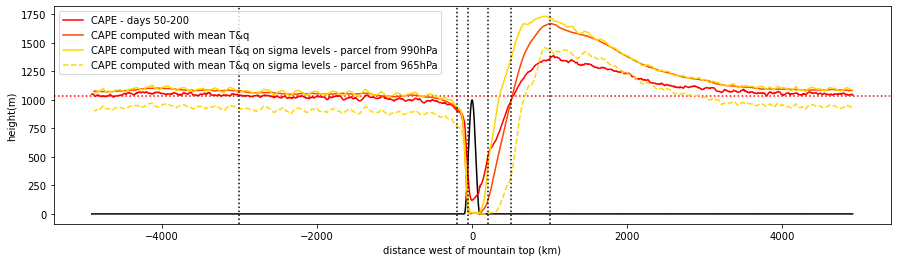

In [51]:
fig, ax = plt.subplots(1,1,figsize=(15,4))
ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("height(m)")
dist=(1635-hgt.west_east)*3

ax.plot(dist,hgt,color='k')
ax.plot(dist ,hrchannel_capecin[0].isel(Time=slice(200,800)).mean(['south_north','Time']),label='CAPE - days 50-200',color='r')
ax.axhline(hrchannel_capecin[0].isel(Time=slice(200,800),west_east=slice(2000,3000)).mean(),color='r',linestyle=':')

dist2=(1635//n-np.arange(3270//n))*3*n
ax.plot(dist2 ,cape_fromskewt,color='orangered', label='CAPE computed with mean T&q')
ax.plot(dist2 ,cape_fromskewt_s,color='gold', label='CAPE computed with mean T&q on sigma levels - parcel from 990hPa')
ax.plot(dist2 ,cape_fromskewt_s_965,color='gold',linestyle='--', label='CAPE computed with mean T&q on sigma levels - parcel from 965hPa')

for d in [-3000,-200,-50,200,500,1000]:
    ax.axvline(d,color='k',linestyle=':')
ax.legend()

 CAPE = 1081.4 J/kg
 CAPE = 934.7 J/kg
 CAPE = 1081.4 J/kg
 CAPE = 144.6 J/kg
 CAPE = 1081.4 J/kg
 CAPE = 93.7 J/kg
 CAPE = 1081.4 J/kg
 CAPE = 965.6 J/kg
 CAPE = 1081.4 J/kg
 CAPE = 1666.7 J/kg


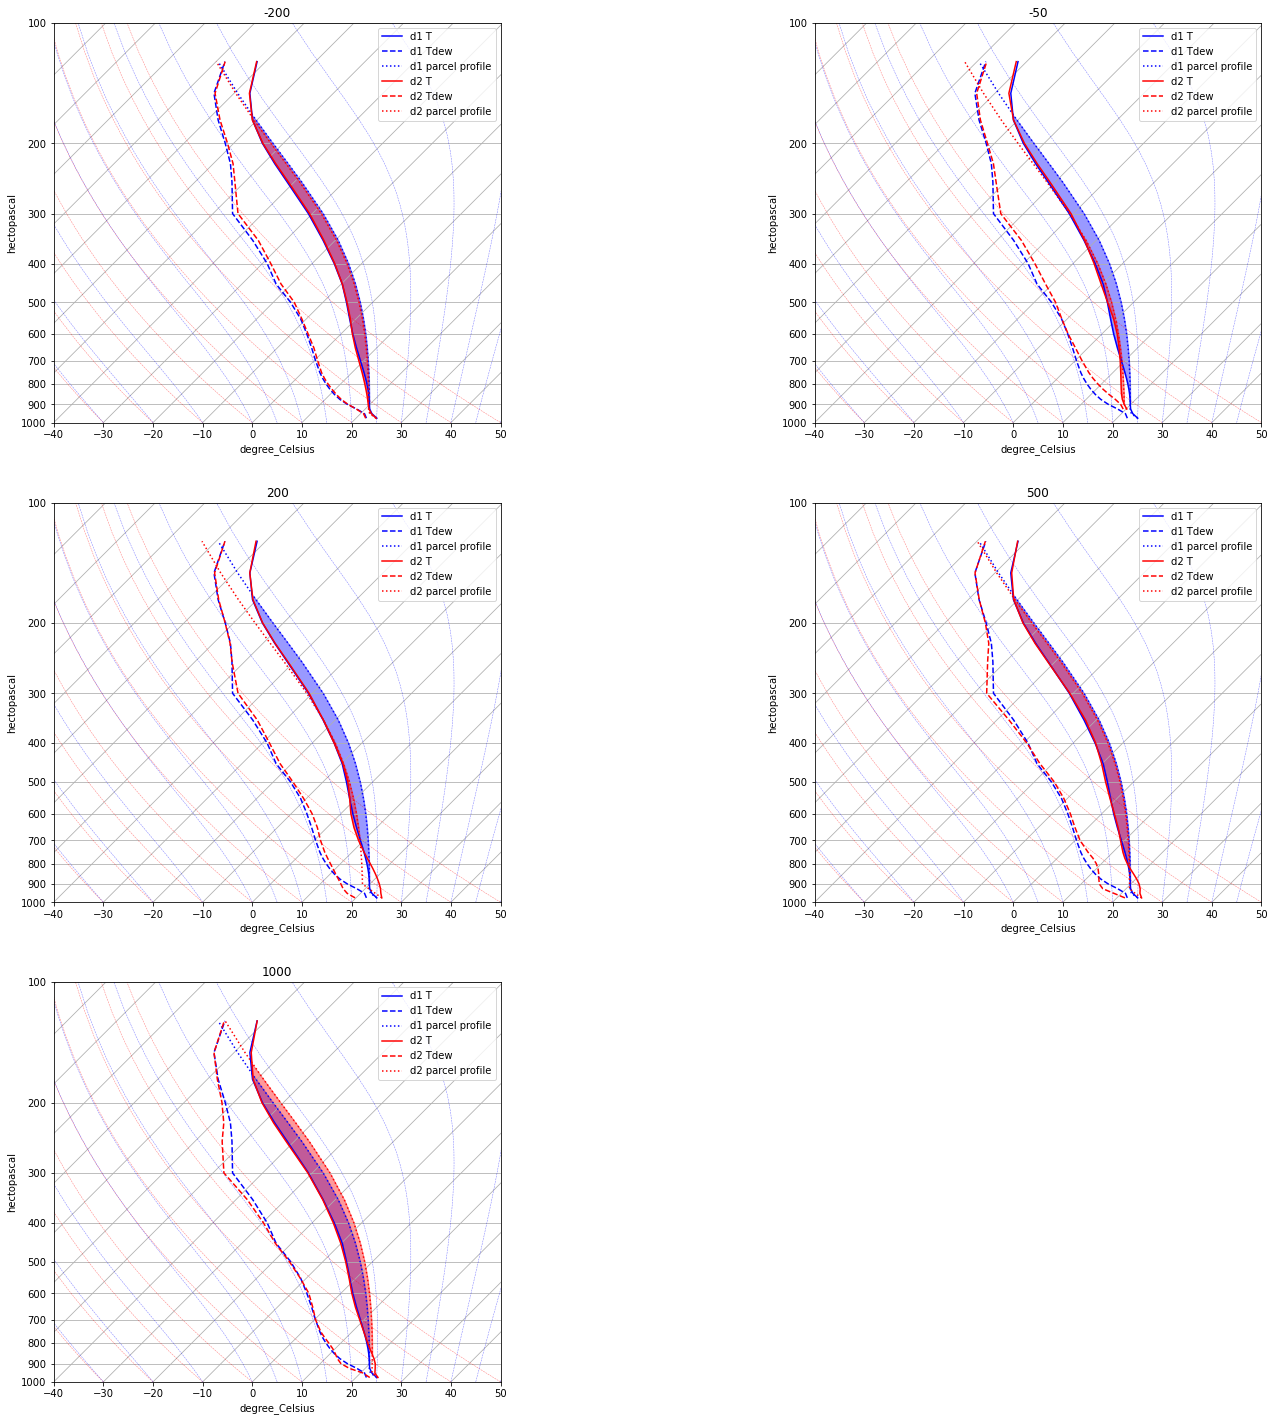

In [235]:
fig = plt.figure(figsize=(25,25))

for i,(d1,d2) in enumerate(zip([-3000]*5,[-200,-50,200,500,1000])):
    skew = SkewT(fig,subplot=(3,2,i+1), rotation=45)
    plot_skewt(tmean_p.sel(distance_from_mtn=d1,method='nearest'),qmean_p.sel(distance_from_mtn=d1,method='nearest'),plevs[1:-4],skew,"blue",'d1')
    plot_skewt(tmean_p.sel(distance_from_mtn=d2,method='nearest'),qmean_p.sel(distance_from_mtn=d2,method='nearest'),plevs[1:-4],skew,"red",'d2')
    skew.ax.set_title(d2)


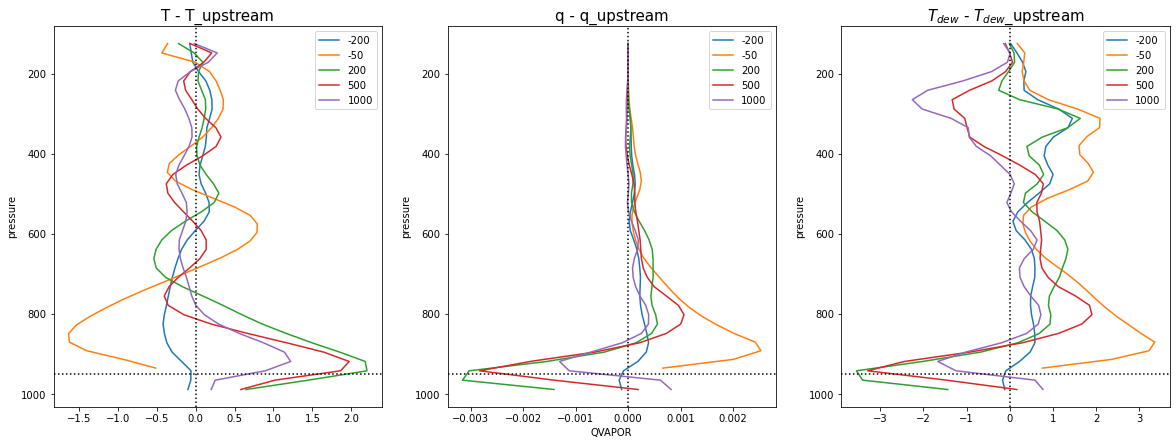

In [225]:
_,ax=plt.subplots(1,3,figsize=(20,7))

def dewpoint(d):
    return mpcalc.dewpoint_from_specific_humidity(np.array(qmean_s.sel(distance_from_mtn=d,method='nearest')),
                                                  np.array(tmean_s.sel(distance_from_mtn=d,method='nearest'))* units.degK,
                                                  np.array(tmean_s.pressure.sel(distance_from_mtn=d,method='nearest'))* units.hPa)/units.degK

for i,(d1,d2) in enumerate(zip([-3000]*5,[-200,-50,200,500,1000])):
    t2=tmean_s.sel(distance_from_mtn=d2,method='nearest').swap_dims({'eta_level':'pressure'})
    q2=qmean_s.sel(distance_from_mtn=d2,method='nearest').swap_dims({'eta_level':'pressure'})
    td2=xr.DataArray(dewpoint(d2),coords=t2.coords)
    t1 =tmean_s.sel(distance_from_mtn=d1,method='nearest').swap_dims({'eta_level':'pressure'})
    td1=xr.DataArray(dewpoint(d1),coords=t1.coords).interp_like(td2)
    t1 =t1.interp_like(t2)
    q1=qmean_s.sel(distance_from_mtn=d1,method='nearest').swap_dims({'eta_level':'pressure'}).interp_like(q2)
    
    (t2-t1).plot(ax=ax[0],y='pressure',yincrease=False,label=d2)
    (q2-q1).plot(ax=ax[1],y='pressure',yincrease=False,label=d2)
    (td2-td1).plot(ax=ax[2],y='pressure',yincrease=False,label=d2)  #((deltaq+deltaT/1000))

titles=["T","q",r"$T_{dew}$"]
for i,a in enumerate(ax):
    a.legend()
    a.axvline(0.,color='k',linestyle=':')
    a.axhline(950.,color='k',linestyle=':')
    a.set_title("%s - %s_upstream"%(titles[i],titles[i]),fontsize=15)


# Re-defining $q_{ref}(p)$ and $b_1(p)$

Let's start from this simple observation : the profiles or moisture variations do not look like the $b_1(p)$ function from Neelin&Zeng, especially in the downstream region.

In [23]:
b1new = np.exp((qmean_s.pressure[:,0]-988)/50).swap_dims({'eta_level':'pressure'})

In [425]:
#p=qmean_s.pressure[:,0]
#b1new = np.exp((p-950)/40)*(1-0.7*np.exp((p-988)/20)) - (np.arctan((p-500)/100)/np.pi+0.5)/8
#b1new=(b1new/b1new.max()).swap_dims({'eta_level':'pressure'})

-200 0.32256662126612484
-50 0.25648182666214675
200 0.02079979993357851
500 -0.006621808033749683
1000 -0.0017968575866443776


Text(0.5, 1.0, 'Upstream moisture deviations')

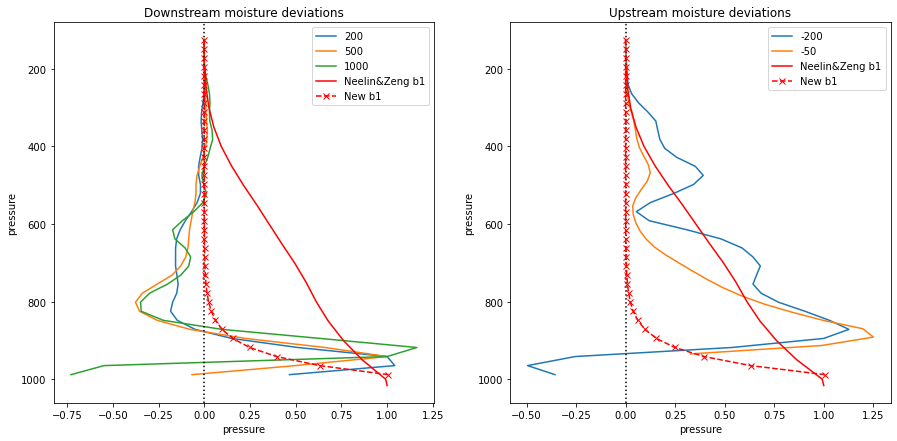

In [25]:
_,ax=plt.subplots(1,2,figsize=(15,7))
for i,(d1,d2) in enumerate(zip([-3000]*5,[-200,-50])):
    q2=qmean_s.sel(distance_from_mtn=d2,method='nearest').swap_dims({'eta_level':'pressure'})
    q1=qmean_s.sel(distance_from_mtn=d1,method='nearest').swap_dims({'eta_level':'pressure'}).interp_like(q2)
    ((q2-q1)/((q2-q1)[4])).plot(ax=ax[1],y='pressure',yincrease=False,label=d2)
    print(d2, float(-pressure_mean((q2-q1)/((q2-q1)[4]))))
for i,(d1,d2) in enumerate(zip([-3000]*5,[200,500,1000])):
    q2=qmean_s.sel(distance_from_mtn=d2,method='nearest').swap_dims({'eta_level':'pressure'})
    q1=qmean_s.sel(distance_from_mtn=d1,method='nearest').swap_dims({'eta_level':'pressure'}).interp_like(q2)
    ((q2-q1)/((q2-q1)[2])).plot(ax=ax[0],y='pressure',yincrease=False,label=d2)
    print(d2, float(-pressure_mean((q2-q1)/((q2-q1)[2]))))
for a in ax:
    a.axvline(0.,linestyle=':',color='k')
    b1.plot(ax=a,y='pressure',yincrease=False,label='Neelin&Zeng b1',color='r')
    b1new.plot(ax=a,y='pressure',yincrease=False,label='New b1',color='r',linestyle='--',marker='x')
    a.legend()
ax[0].set_title("Downstream moisture deviations")
ax[1].set_title("Upstream moisture deviations")

This profile function has been used to match the downstream profiles of moisture deviation; which is of course debatable, but nevertheless what makes the most sense if the goal is to model the rain shadow length scale. One idea could be to use a different $b_1$ upstream and downstream, but it's too much of a fitting and too convoluted for the present paper.

Having such a $b_1$ solves all previous troubles because $\hat b_{1,new} = 0.06$, vs $\hat b_{1,NZ} = 0.4$, and $L\propto \hat b_1$.

In [26]:
print(r"\hat b_{1,NZ} = %.3f"%(-pressure_mean(b1)))
print(r"\hat b_{1,new} = %.3f"%(-pressure_mean(b1new)))

\hat b_{1,NZ} = 0.392
\hat b_{1,new} = 0.059


Now that we have a $b_1$, we can also define a $q_{\text{ref}}$, which allows a more rigorous definition of $q_1$ than the fitting I was performing before.
We define $q_{\text{ref}}(p) = q_{\text{upstream}}(p) - \alpha b_1(p)$, where $\alpha$ is chosen such that the $CAPE$ given by the upstream $T$ sounding and the $q_{\text{ref}}(p)$ sounding is just 0.

In [1]:
2.26e6*0.003

6780.0

In [27]:
alpha=0.003
#alpha=0.004
qref = qmean_s.sel(distance_from_mtn=d1,method='nearest').swap_dims({'eta_level':'pressure'})-alpha*b1new
qref_eta = qref.swap_dims({'pressure':'eta_level'})

 CAPE = 1066.6 J/kg
 CAPE = 0.0 J/kg


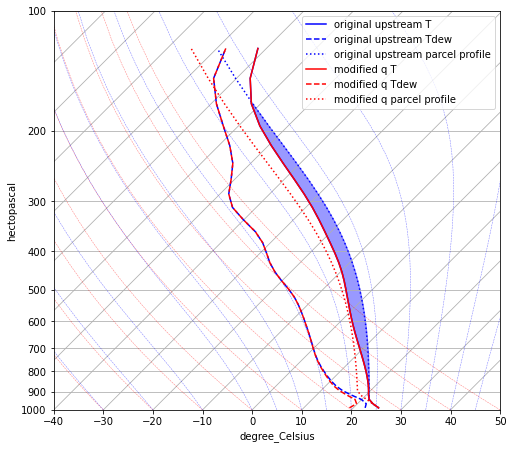

In [28]:
fig = plt.figure(figsize=(8,8))
d1=-3000
skew = SkewT(fig, rotation=45)
plot_skewt(tmean_s.sel(distance_from_mtn=d1,method='nearest'),qmean_s.sel(distance_from_mtn=d1,method='nearest'),np.array(qmean_s.pressure.sel(distance_from_mtn=d1,method='nearest')),skew,"b",'original upstream')
plot_skewt(tmean_s.sel(distance_from_mtn=d1,method='nearest'),qref,np.array(qmean_s.pressure.sel(distance_from_mtn=d1,method='nearest')),skew,"r",'modified q')

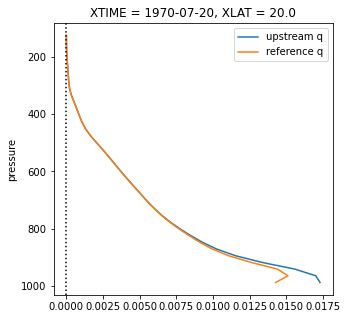

In [29]:
plt.figure(figsize=(5,5))
qmean_s.sel(distance_from_mtn=d1,method='nearest').swap_dims({'eta_level':'pressure'}).plot(y='pressure',yincrease=False,label='upstream q')
qref.plot(y='pressure',yincrease=False,label='reference q')
plt.axvline(0.,linestyle=':',color='k')
plt.legend()

# Diagnosing q1 from WRF 

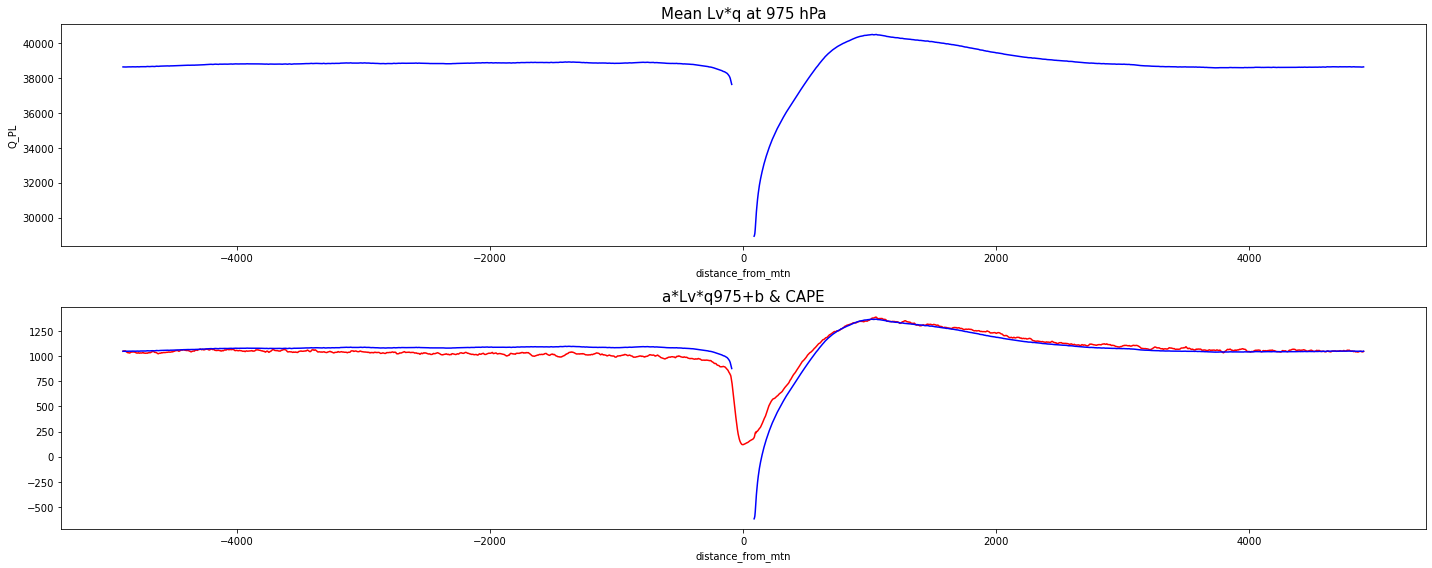

In [36]:
fig,ax=plt.subplots(2,1,figsize=(20,8))
q0 = (2.26e6*qmean_p[0])
q0[1607:1665]=np.nan
q0.plot(ax=ax[0],color='b')
ax[0].set_title("Mean Lv*q at 975 hPa", fontsize=15)
           
realCAPE.plot(ax=ax[1],color='r')
a = (realCAPE[-1]-realCAPE[1300])/(q0[-1]-q0[1300])
b = realCAPE[-1] - a*q0[-1]
(a*q0+b).plot(ax=ax[1],color='b')
ax[1].set_title("a*Lv*q975+b & CAPE", fontsize=15)
fig.tight_layout()

Text(0.5, 1.0, 'a*Lv*q975+b & CAPE')

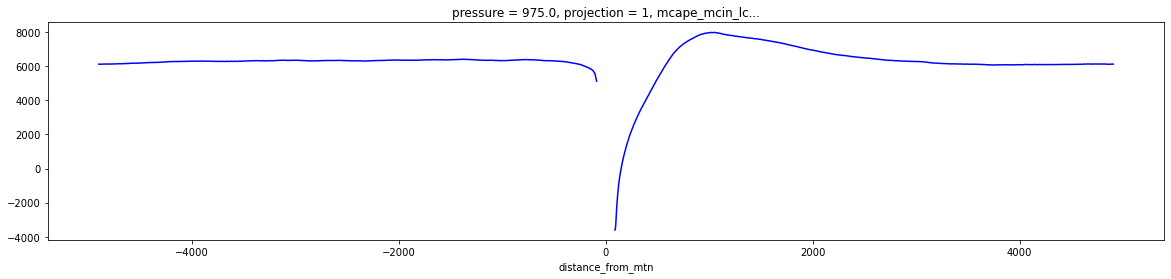

In [37]:
plt.figure(figsize=(20,4))
a = (realCAPE[-1]-realCAPE[1300])/(q0[-1]-q0[1300])
b = realCAPE[-1] - a*q0[-1]
(q0+b/a).plot(color='b')
ax[1].set_title("a*Lv*q975+b & CAPE", fontsize=15)

Text(0.5, 1.0, 'Mean Lv*q at 950 hPa')

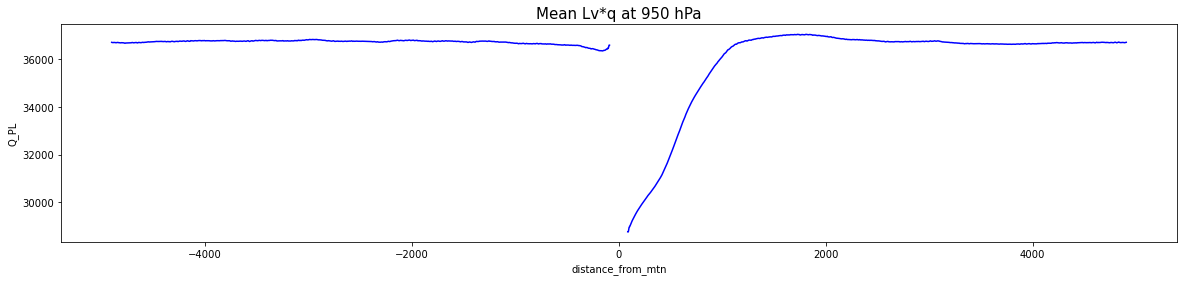

In [292]:
plt.figure(figsize=(20,4))
q0 = (2.26e6*qmean_p[1])
q0[1607:1665]=np.nan
q0.plot(color='b')
plt.title("Mean Lv*q at 950 hPa", fontsize=15)

## Correcting with the effects of T1

What essentially sets the CAPE, in the above soundings, is the LCL temperature, which is grossly $(T_s + T_{dew,s})/2$. Hence variations in CAPE are to first order proportional to $\dfrac{\delta T_s + \delta T_{dew,s}}{2}$.

Now, $T_{dew} \simeq T - \frac{100-RH}{5} = T - 20 + \dfrac{20}{q_{sat}} q \simeq T - 20 + 2000 q$ (temperatures in Kelvin and q in kg/kg). Hence $\delta T_{dew,s} \simeq \delta T_s + 2000 \delta q$, and $\delta CAPE \propto \delta T_s + 1000 \delta q$.

The moisture variation $\delta q_{eff}$ that gives the same $CAPE$ variation without any $T$ variation is thus $\boxed{\delta q_{eff} = \delta q + \delta T_s / 1000}$

Text(0.5, 1.0, 'a*Lv*$\\delta q_{eff}(950)$+b & CAPE')

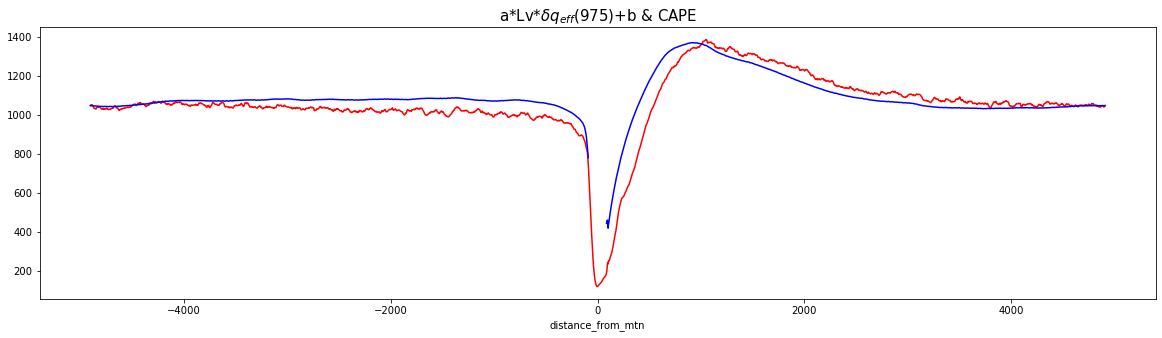

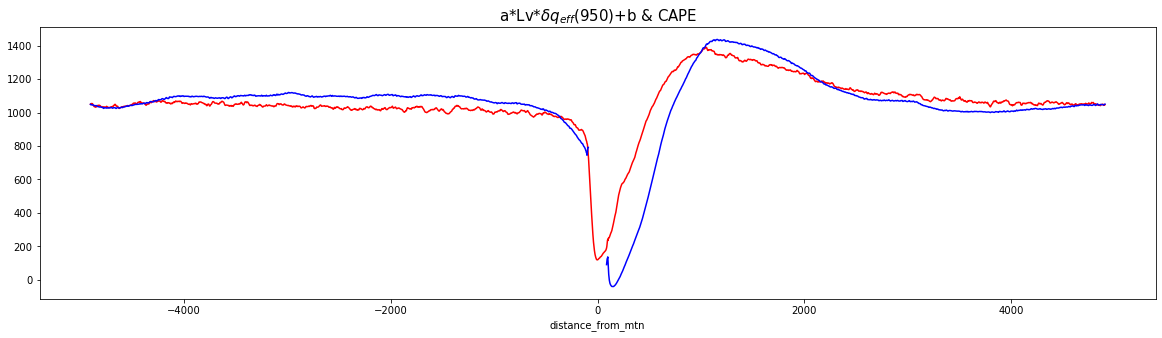

In [309]:
dq_eff=((qmean_p-qmean_p.sel(distance_from_mtn=-3000,method='nearest'))+(tmean_p-tmean_p.sel(distance_from_mtn=-3000,method='nearest'))/1000)

plt.figure(figsize=(20,5))
Lvdq_eff = (2.26e6*dq_eff[0])
Lvdq_eff[1607:1665]=np.nan
realCAPE.plot(color='r')
a = (realCAPE[-1]-realCAPE[1300])/(Lvdq_eff[-1]-Lvdq_eff[1300])
b = realCAPE[-1] - a*Lvdq_eff[-1]
(a*Lvdq_eff+b).plot(color='b')
plt.title(r"a*Lv*$\delta q_{eff}(975)$+b & CAPE", fontsize=15)

plt.figure(figsize=(20,5))
Lvdq_eff = (2.26e6*dq_eff[1])
Lvdq_eff[1607:1665]=np.nan
realCAPE.plot(color='r')
a = (realCAPE[-1]-realCAPE[1300])/(Lvdq_eff[-1]-Lvdq_eff[1300])
b = realCAPE[-1] - a*Lvdq_eff[-1]
(a*Lvdq_eff+b).plot(color='b')
plt.title(r"a*Lv*$\delta q_{eff}(950)$+b & CAPE", fontsize=15)

Text(0.5, 1.0, 'a*Lv*$\\delta q_{eff}(950)$+b & CAPE')

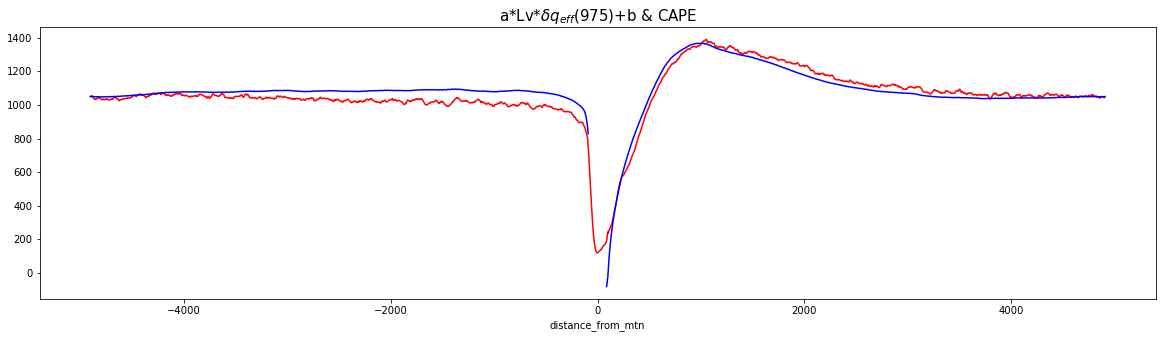

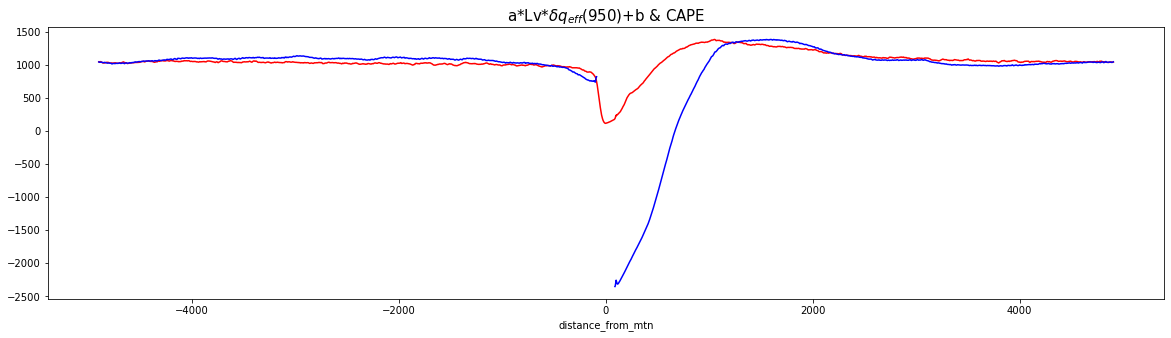

In [22]:
dq_eff=((qmean_p-qmean_p.sel(distance_from_mtn=-3000,method='nearest'))+(tmean_p-tmean_p.sel(distance_from_mtn=-3000,method='nearest'))/2260)

plt.figure(figsize=(20,5))
Lvdq_eff = (2.26e6*dq_eff[0])
Lvdq_eff[1607:1665]=np.nan
realCAPE.plot(color='r')
a = (realCAPE[-1]-realCAPE[1300])/(Lvdq_eff[-1]-Lvdq_eff[1300])
b = realCAPE[-1] - a*Lvdq_eff[-1]
(a*Lvdq_eff+b).plot(color='b')
plt.title(r"a*Lv*$\delta q_{eff}(975)$+b & CAPE", fontsize=15)

plt.figure(figsize=(20,5))
Lvdq_eff = (2.26e6*dq_eff[1])
Lvdq_eff[1607:1665]=np.nan
realCAPE.plot(color='r')
a = (realCAPE[-1]-np.max(realCAPE))/(Lvdq_eff[-1]-np.max(Lvdq_eff))
b = realCAPE[-1] - a*Lvdq_eff[-1]
(a*Lvdq_eff+b).plot(color='b')
plt.title(r"a*Lv*$\delta q_{eff}(950)$+b & CAPE", fontsize=15)

Text(0.5, 1.0, 'Lv*$\\delta q_{eff}(950)$+b/a')

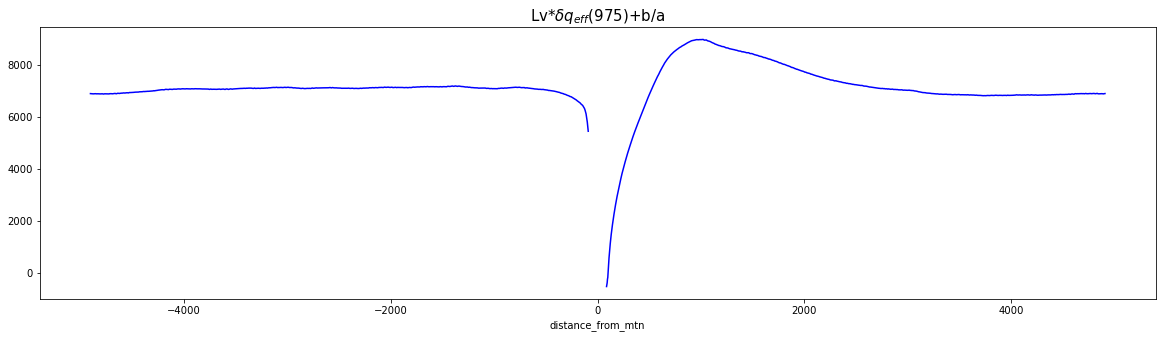

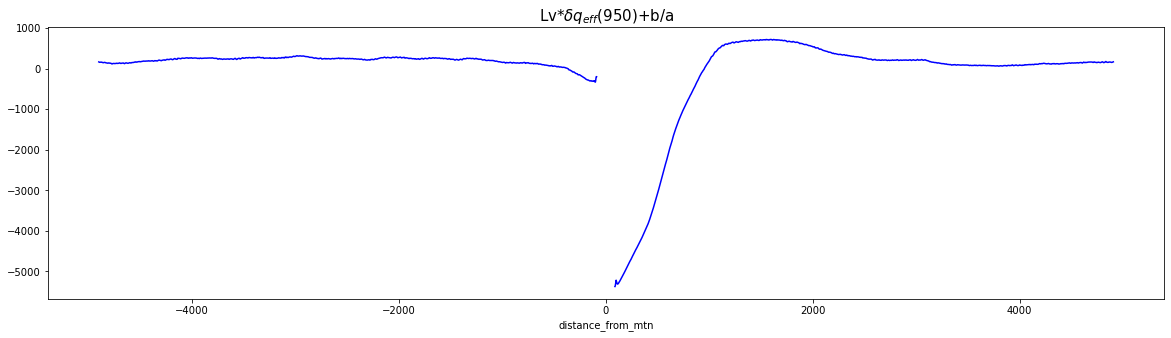

In [24]:
dq_eff=((qmean_p-qmean_p.sel(distance_from_mtn=-3000,method='nearest'))+(tmean_p-tmean_p.sel(distance_from_mtn=-3000,method='nearest'))/2260)

plt.figure(figsize=(20,5))
Lvdq_eff = (2.26e6*dq_eff[0])
Lvdq_eff[1607:1665]=np.nan
a = (realCAPE[-1]-realCAPE[1300])/(Lvdq_eff[-1]-Lvdq_eff[1300])
b = realCAPE[-1] - a*Lvdq_eff[-1]
(Lvdq_eff+b/a).plot(color='b')
plt.title(r"Lv*$\delta q_{eff}(975)$+b/a", fontsize=15)

plt.figure(figsize=(20,5))
Lvdq_eff = (2.26e6*dq_eff[1])
Lvdq_eff[1607:1665]=np.nan
a = (realCAPE[-1]-realCAPE[1300])/(Lvdq_eff[-1]-Lvdq_eff[1300])
b = realCAPE[-1] - a*Lvdq_eff[-1]
(Lvdq_eff+b/a).plot(color='b')
plt.title(r"Lv*$\delta q_{eff}(950)$+b/a", fontsize=15)

# Diagnosing q1 from WRF 

The goal here is to estimate $q_1$, which has been defined such that $$q(x,p) = q_{ref}(p) + q_1(x)b_1(p)$$

There are several ways to do so : we could define $$q_1(x) = \dfrac{q(x,p_0) - q_{ref}(p_0)}{b_1(p_0)} \text{ for a fixed pressure }p_0$$
or
$$q_1(x) = \dfrac{\int_{p_0}^{p_1}q(x,p) - q_{ref}(p) dp}{\int_{p_0}^{p_1} b_1dp}$$
or even 
$$q_1(x) = \dfrac{\int_{p_{tropopause}}^{p_{surface}}q(x,p) - q_{ref}(p) dp}{\int_{p_{tropopause}}^{p_{surface}} b_1dp}$$

The last choice gives rise to a $q_1$ that doesn't represent CAPE variations at all, see below. We explore the two other choices subsequently.

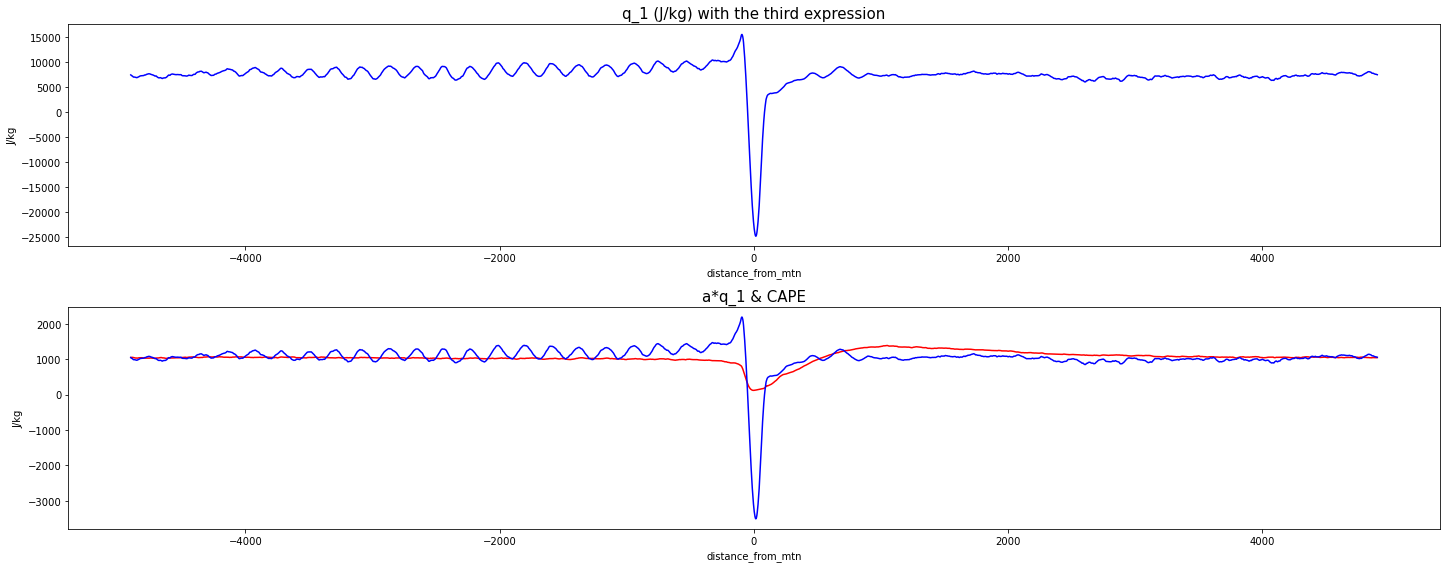

In [431]:
fig,ax=plt.subplots(2,1,figsize=(20,8))
q1 = (2.26e6*(qmean_s-qref_eta).mean('eta_level')/b1new.mean('pressure'))
q1.plot(ax=ax[0],color='b')
ax[0].set_title("q_1 (J/kg) with the third expression", fontsize=15)
           
realCAPE.plot(ax=ax[1],color='r')
a = realCAPE[-1]/q1[-1]
(a*q1).plot(ax=ax[1],color='b')
ax[1].set_title("a*q_1 & CAPE", fontsize=15)
fig.tight_layout()
for a in ax:
    a.set_ylabel('J/kg')

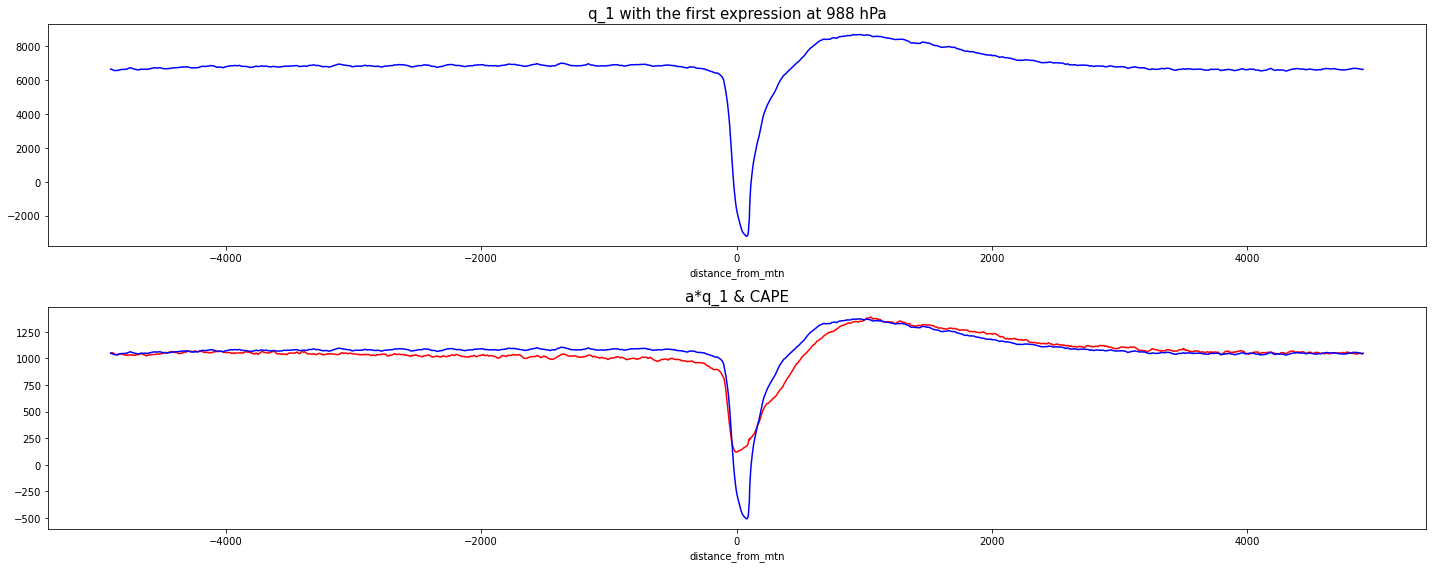

In [432]:
fig,ax=plt.subplots(2,1,figsize=(20,8))
q1 = (2.26e6*(qmean_s[0]-qref_eta[0]))/b1new[0]
q1.plot(ax=ax[0],color='b')
ax[0].set_title("q_1 with the first expression at 988 hPa", fontsize=15)
           
realCAPE.plot(ax=ax[1],color='r')
a = (realCAPE[-1])/(q1[-1])
(a*q1).plot(ax=ax[1],color='b')
ax[1].set_title("a*q_1 & CAPE", fontsize=15)
fig.tight_layout()

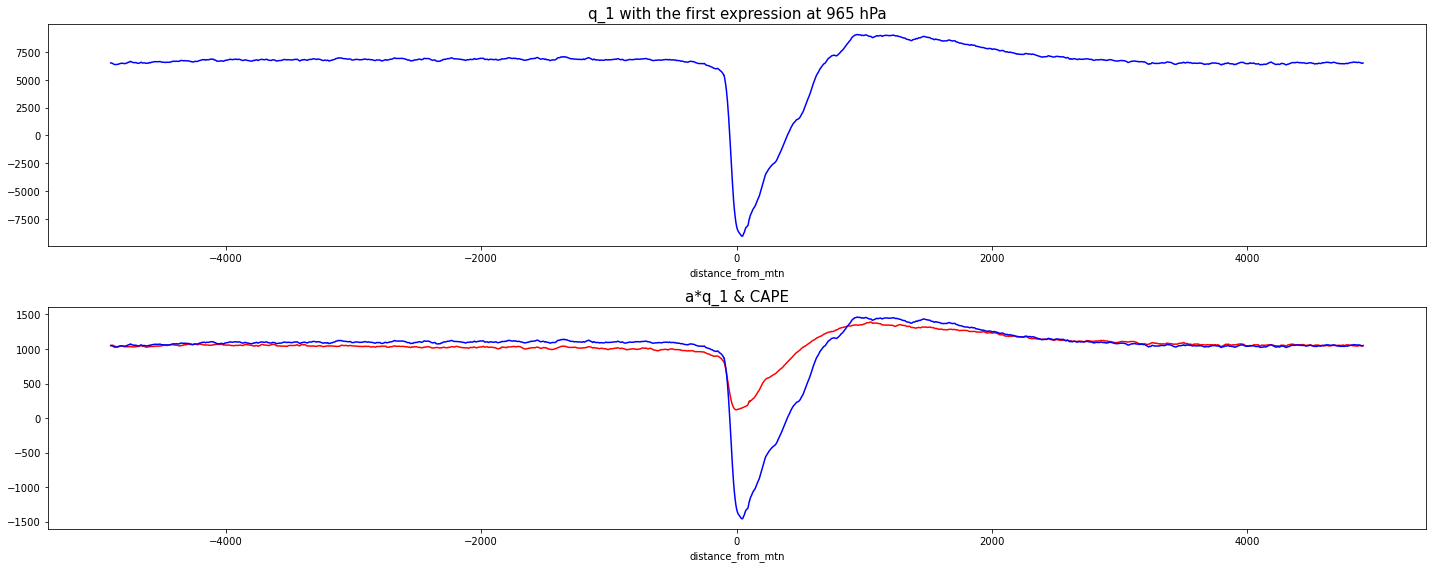

In [433]:
fig,ax=plt.subplots(2,1,figsize=(20,8))
q1 = (2.26e6*(qmean_s[1]-qref_eta[1]))/b1new[1]
q1.plot(ax=ax[0],color='b')
ax[0].set_title("q_1 with the first expression at 965 hPa", fontsize=15)
           
realCAPE.plot(ax=ax[1],color='r')
a = (realCAPE[-1])/(q1[-1])
(a*q1).plot(ax=ax[1],color='b')
ax[1].set_title("a*q_1 & CAPE", fontsize=15)
fig.tight_layout()

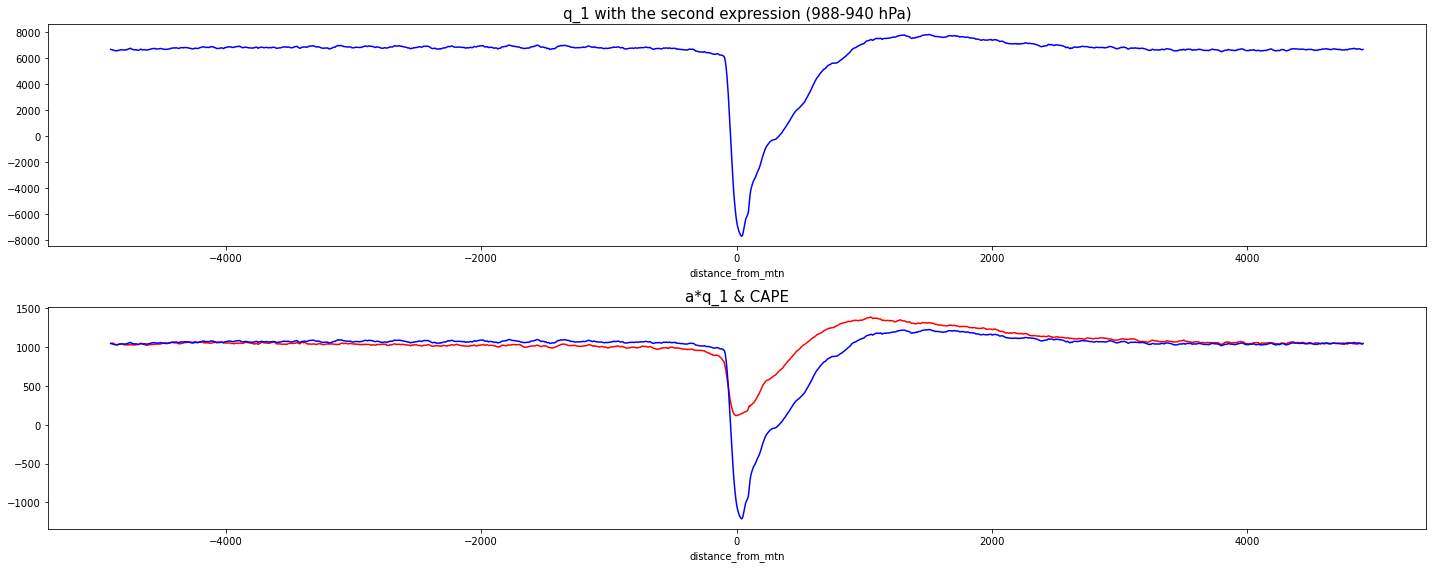

In [434]:
fig,ax=plt.subplots(2,1,figsize=(20,8))
q1 = (2.26e6*(qmean_s[:3].mean('eta_level')-qref_eta[:3].mean('eta_level'))/b1new[:3].mean('pressure'))
q1.plot(ax=ax[0],color='b')
ax[0].set_title("q_1 with the second expression (988-940 hPa)", fontsize=15)
           
realCAPE.plot(ax=ax[1],color='r')
a = (realCAPE[-1])/(q1[-1])
(a*q1).plot(ax=ax[1],color='b')
ax[1].set_title("a*q_1 & CAPE", fontsize=15)
fig.tight_layout()


## BL MSE variations instead of q_1

The original set of equations we had was :
$$\left\{\begin{array}{cccl} 
& -\omega_1 M_s &=& \hat Q_c - \hat R \\
\hat b_1\mathbf{u_h}\cdot\nabla q_1 &+ \omega_1 M_q &=& \hat Q_q + \hat E
\end{array} \right.$$

With the energy constraint $\hat Q_q = -\hat Q_c$, and $\hat R = \hat E$ for simplicity.
Those were reduced to an MSE equation (here, a moisture equation because $T_1$ is assumed zero :

$$\hat b_1\mathbf{u_h}\cdot\nabla q_1 + \dfrac{M_h}{M_s}(\hat Q_c - \hat E) = 0$$

Now, we can revisit the WTG assumption in the boundary layer by using the same profile for temperature and moisture variations :

$$\left\{\begin{array}{cccl} 
\hat b_1\mathbf{u_h}\cdot\nabla T_1 &-\omega_1 M_s &=& \hat Q_c - \hat R \\
\hat b_1\mathbf{u_h}\cdot\nabla q_1 &+ \omega_1 M_q &=& \hat Q_q + \hat E
\end{array} \right.$$
which is now reduced to 
$$\hat b_1\mathbf{u_h}\cdot\nabla h_1 + \dfrac{M_h}{M_s}(\hat Q_c - \hat E) = 0 \text{  with  } h_1=T_1+q_1$$

Now, the convective closure we used was $\hat Q_c \propto q_1$, but we can easily justify using $\hat Q_c \propto h_1$ instead

In [435]:
dmse = 2.26e6*(qmean_s-qref_eta)+1004*(tmean_s-tmean_s.sel(distance_from_mtn=-3000,method='nearest'))

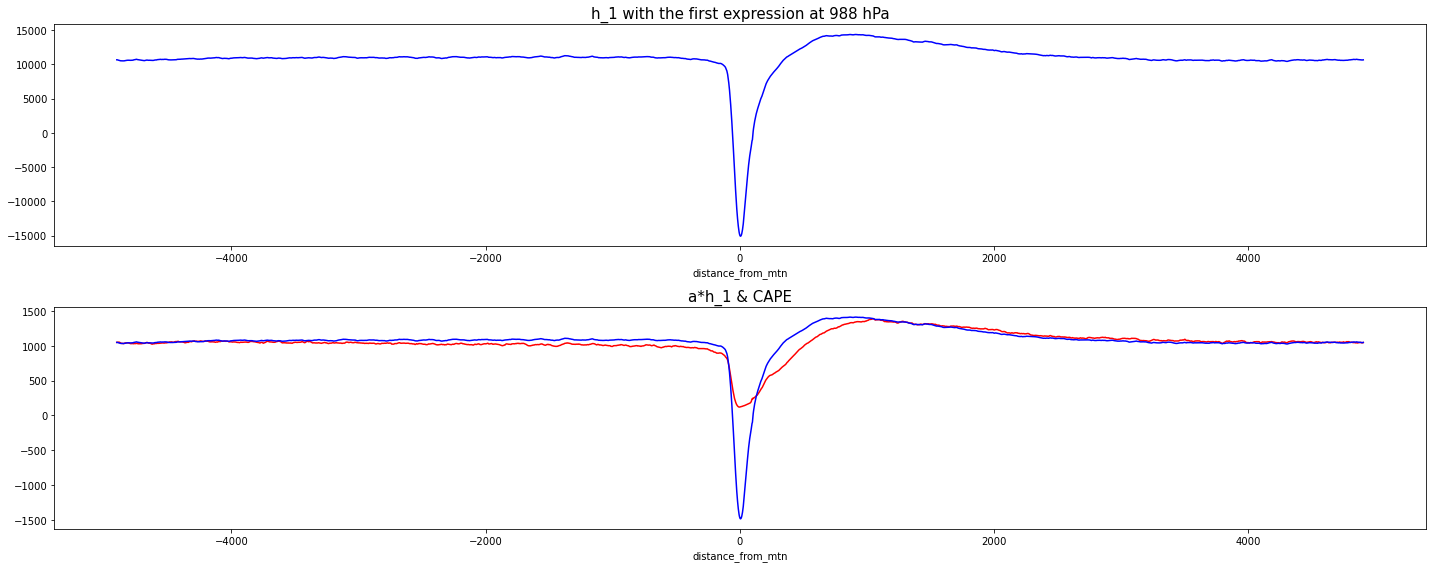

In [453]:
fig,ax=plt.subplots(2,1,figsize=(20,8))
q1=dmse[0]/b1new[0]
q1.plot(ax=ax[0],color='b')
ax[0].set_title("h_1 with the first expression at 988 hPa", fontsize=15)
           
realCAPE.plot(ax=ax[1],color='r')
a = (realCAPE[-1])/(q1[-1])
(a*q1).plot(ax=ax[1],color='b')
ax[1].set_title("a*h_1 & CAPE", fontsize=15)
fig.tight_layout()

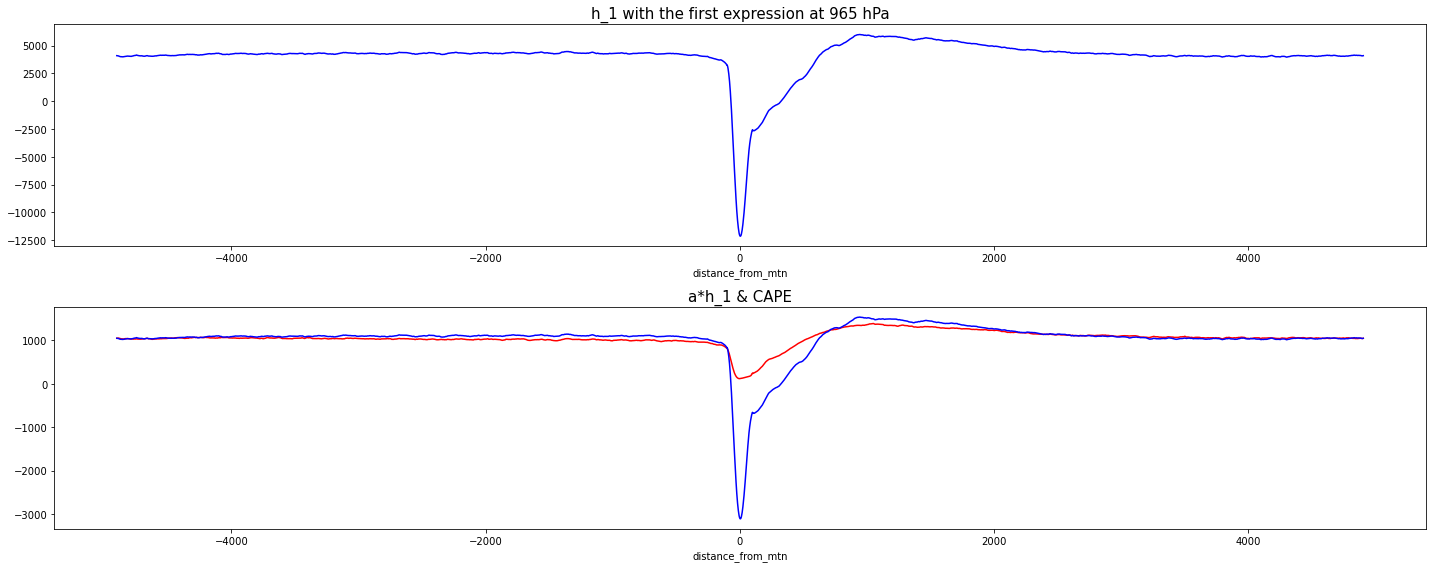

In [455]:
fig,ax=plt.subplots(2,1,figsize=(20,8))
q1=dmse[1]/b1new[1]
q1.plot(ax=ax[0],color='b')
ax[0].set_title("h_1 with the first expression at 965 hPa", fontsize=15)
           
realCAPE.plot(ax=ax[1],color='r')
a = (realCAPE[-1])/(q1[-1])
(a*q1).plot(ax=ax[1],color='b')
ax[1].set_title("a*h_1 & CAPE", fontsize=15)
fig.tight_layout()

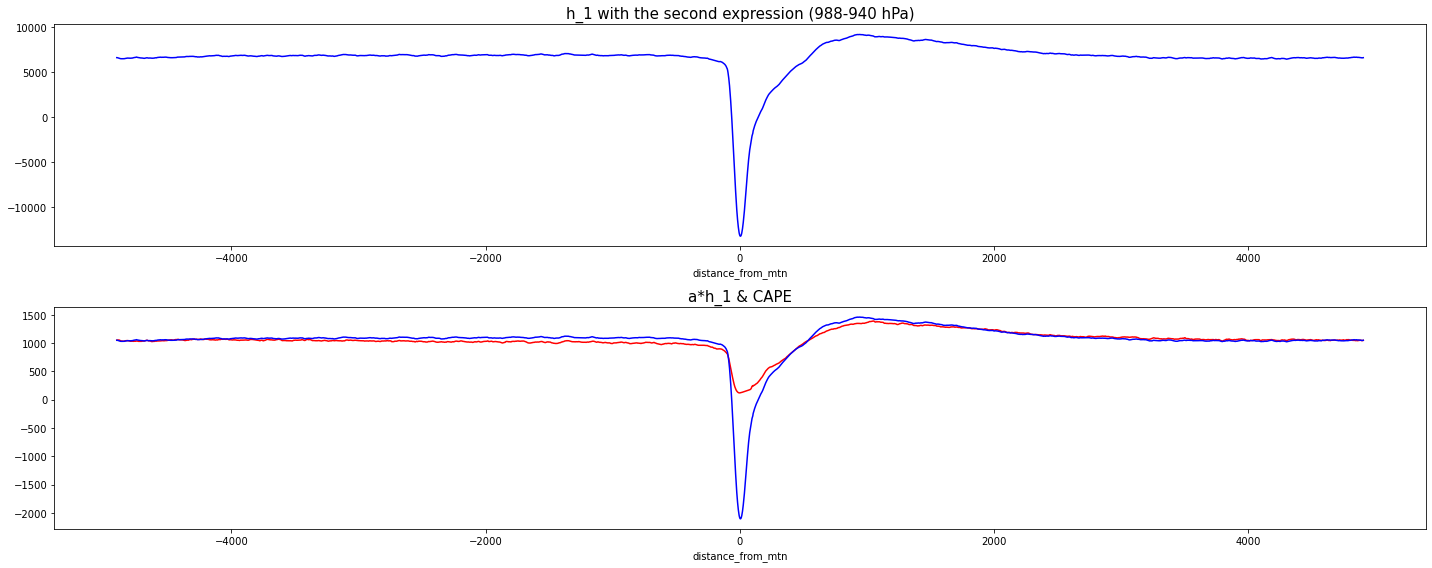

In [456]:
fig,ax=plt.subplots(2,1,figsize=(20,8))
q1 = dmse[:2].mean('eta_level')/b1new[:2].mean('pressure')
q1.plot(ax=ax[0],color='b')
ax[0].set_title("h_1 with the second expression (988-940 hPa)", fontsize=15)
           
realCAPE.plot(ax=ax[1],color='r')
a = (realCAPE[-1])/(q1[-1])
(a*q1).plot(ax=ax[1],color='b')
ax[1].set_title("a*h_1 & CAPE", fontsize=15)
fig.tight_layout()


# Determining constants for the analytical model 

Now that we have estimates of $q_1$, we can go back to our analytical model and figure out unknown constants.

Start with out equation:

$$\hat b_1\mathbf{u_h}\cdot\nabla q_1 + \dfrac{M_h}{M_s}(\hat Q_c - \hat E) = 0$$

Previously, what we did is to write $\hat Q_c = CAPE / \tau_c = \alpha q_1 / \tau_c$. Here, we can abstract further and simply write $\hat Q_c = \gamma q_1$. We deduce the equation 

$$\dfrac{\mathrm{d}q_1}{\mathrm{d}x} + \dfrac{1}{L}(\gamma'q_1 - \hat E/\gamma_0) = 0, \text{    where    } L = \dfrac{M_s}{M_h} \hat b_1 u_h \dfrac{1}{\gamma_0}$$

To estimate $\gamma_0$, we note that $\hat Q_c \simeq L_v P /M$ (where $M$ is the tropospheric mass and $P$ the precipitation). The estimates for $q_1$ depend on which level/method we choose but range from $5000$ to $10000 J/kg$ (1 to 3 g/kg). 

This gives $1.6\times 10^{-6} s^{-1} \leq \gamma_0 \leq 3.3\times 10^{-6} s^{-1}$, and $900km \leq L \leq 1800km $

To fit the actual $q_1$ (or CAPE) profile, we need $L\simeq 500$ km.

In [126]:
Qc = 4.5/86400*2.5e6/8000 #J/kg/s
Qc

0.016276041666666668

In [451]:
b1hat=0.06
u=10
Ms_Mh=5
L_km = b1hat*u*Ms_Mh/(Qc/10000)/1000
L_km

1843.1999999999998

## With another profile

If we examine the downstream moisture deviation profiles closer, there is a clear negative part in the upper troposphere, indicative of a cooling of the mid-troposphere which favors the CAPE recovery. In terms of $\hat b_1$, it simply gets reduced; here is an example $b_1$ profile we could use to account for this :

In [443]:
p=qmean_s.pressure[:,0]
b1new = np.exp((p-950)/40)*(1-0.7*np.exp((p-988)/20)) - (np.arctan((p-500)/100)/np.pi+0.5)/8
b1new=(b1new/b1new.max()).swap_dims({'eta_level':'pressure'})

Text(0.5, 1.0, 'Downstream moisture deviations')

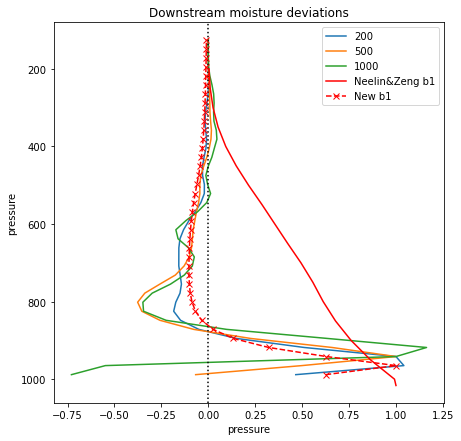

In [446]:
_,ax=plt.subplots(1,1,figsize=(7,7))
for i,(d1,d2) in enumerate(zip([-3000]*5,[200,500,1000])):
    q2=qmean_s.sel(distance_from_mtn=d2,method='nearest').swap_dims({'eta_level':'pressure'})
    q1=qmean_s.sel(distance_from_mtn=d1,method='nearest').swap_dims({'eta_level':'pressure'}).interp_like(q2)
    ((q2-q1)/((q2-q1)[2])).plot(ax=ax,y='pressure',yincrease=False,label=d2)

ax.axvline(0.,linestyle=':',color='k')
b1.plot(ax=ax,y='pressure',yincrease=False,label='Neelin&Zeng b1',color='r')
b1new.plot(ax=ax,y='pressure',yincrease=False,label='New b1',color='r',linestyle='--',marker='x')
ax.legend()
ax.set_title("Downstream moisture deviations")

In [447]:
print(r"\hat b_{1,new} = %.3f"%(-pressure_mean(b1new)))

\hat b_{1,new} = 0.019


## Results

In [457]:
from scipy.integrate import cumtrapz
def cape_analytical_Lx(x,f,L,CAPERCE,alpha):
    """Analytical solution to equation (3), with L and CAPERCE varying with x"""
    c = cumtrapz(1/(f*L),x,initial=0)
    return CAPERCE * np.exp(-c) * (1+cumtrapz(alpha/L*np.exp(c),x,initial=0))


In [464]:
CAPERCE = 1000

In [459]:
# f from simulation
x = 1000*(1635-hgt.west_east)*3 #+ 4902000
x = x[::-1] 

cape=hrchannel_capecin[0].isel(Time=slice(200,400)).mean(['south_north','Time'])
pr = hrchannelprecip.isel(Time=slice(200,400)).mean(['south_north','Time'])
tauc=cape/(2.26e6*pr/86400/8000)
fsim = np.array(tauc[::-1]/tauc.isel(west_east=slice(2000,3000)).mean())

print("baseline tau_c in simulation : %.1e s"%(tauc.isel(west_east=slice(2000,3000)).mean()))

baseline tau_c in simulation : 7.6e+04 s


In [460]:
evap = hrchannel.QFX.isel(Time=slice(200,400)).mean(['south_north','Time'])
alpha = np.array(evap/evap.mean())[::-1]

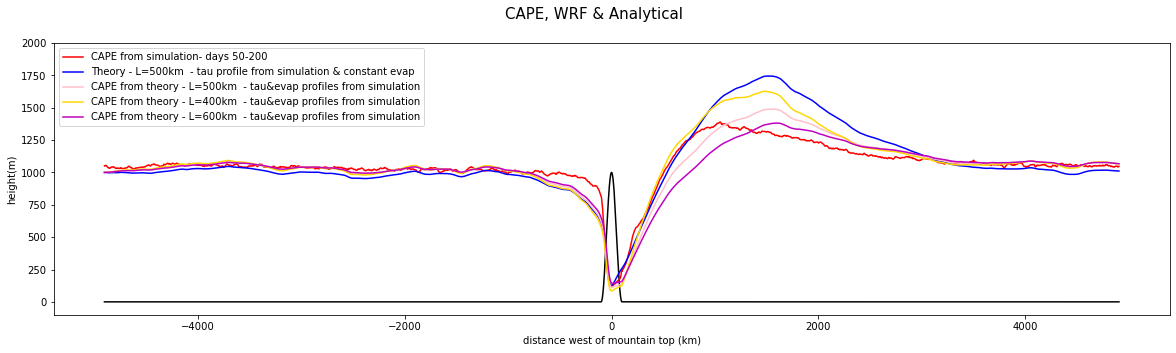

In [469]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("height(m)")
dist=(1635-hgt.west_east)*3

ax.plot(dist,hgt,color='k')
ax.plot(dist ,hrchannel_capecin[0].isel(Time=slice(200,800)).mean(['south_north','Time']),label='CAPE from simulation- days 50-200',color='r')

ax.plot(dist,cape_analytical_Lx(x,fsim,500e3,CAPERCE,1.)[::-1],color="blue",label='Theory - L=500km  - tau profile from simulation & constant evap')
ax.plot(dist,cape_analytical_Lx(x,fsim,500e3,CAPERCE,alpha)[::-1],color="pink",label='CAPE from theory - L=500km  - tau&evap profiles from simulation')
ax.plot(dist,cape_analytical_Lx(x,fsim,400e3,CAPERCE,alpha)[::-1],color="gold",label='CAPE from theory - L=400km  - tau&evap profiles from simulation')
ax.plot(dist,cape_analytical_Lx(x,fsim,600e3,CAPERCE,alpha)[::-1],color="m",label='CAPE from theory - L=600km  - tau&evap profiles from simulation')


ax.set_ylim(-100,2000)


fig.suptitle("CAPE, WRF & Analytical", fontsize=15)
ax.legend()

## Justyfing the WTG assumption, even above the mountain ?

Before plugging vertical modes and using WTG, our equations were:

$$\left\{\begin{array}{ccccl} 
\mathbf{u_h}\cdot\nabla T  &+& \omega\dfrac{\partial s}{\partial p} &=& Q_c - R \\
\mathbf{u_h}\cdot\nabla q  &+& \omega\dfrac{\partial q}{\partial p} &=& Q_q + E
\end{array} \right.$$

Let's assume we want to take into account the dry mountain wave. We can use the following decompositions :

$$\begin{array}{ccccccl} 
\omega &=& \omega_{\text{dry}}(x,p) &+& \omega_1(x)\Omega_1(p)\\
q &=& q_0(p) &+& q_1(x) b_1(p)\\
T &=& T_0(p) &+& T_{\text{dry}}(x,p) &+& T_1(x) a_1(p)
\end{array}$$

We get

$$\left\{\begin{array}{cccccccl} 
\mathbf{u_h}\cdot\nabla T_{\text{dry}} &+& a_1(p)\mathbf{u_h}\cdot\nabla T_1 &+& \omega_{\text{dry}}\dfrac{\partial s}{\partial p} &+&  \omega_1\Omega_1(p)\dfrac{\partial s}{\partial p} &=& Q_c - R \\
&&b_1(p)\mathbf{u_h}\cdot\nabla q_1 &+& \omega_{\text{dry}}\dfrac{\partial q}{\partial p} &+& \omega_1\Omega_1(p)\dfrac{\partial q}{\partial p} &=& Q_q + E
\end{array} \right.$$

There, we will suppose $a_1(p)\mathbf{u_h}\cdot\nabla T_1 \ll \mathbf{u_h}\cdot\nabla T_{\text{dry}}$ (WTG except for dry motions), $\dfrac{\partial s}{\partial p} \simeq \dfrac{\partial s_0}{\partial p}$ and $\dfrac{\partial q}{\partial p} \simeq \dfrac{\partial q_0}{\partial p}$.

We proceed with vertically averaging (a hat will denote a vertical average in pressure coordinates), and denote :
$$\begin{array}{ccl} 
M_s &=& -\widehat{\Omega_1 \dfrac{\partial s_0}{\partial p}}\\
M_q &=&  \widehat{\Omega_1 \dfrac{\partial q_0}{\partial p}}\\
Q_{\text{adv,dry}} &=&  -\widehat{\mathbf{u_h}\cdot\nabla T_{\text{dry}}}\\
Q_{\text{adiab,dry}} &=&  -\widehat{\omega_{\text{dry}}\dfrac{\partial s_0}{\partial p}}\\
\end{array}$$

There, we obtain :
$$\left\{\begin{array}{cccccl} 
& -\omega_1 M_s &=& \hat Q_c - \hat R + Q_{\text{adiab,dry}} &+& Q_{\text{adv,dry}}  \\
\hat b_1\mathbf{u_h}\cdot\nabla q_1 &+ \omega_1 M_q &=& \hat Q_q + \hat E -\widehat{\omega_{\text{dry}}\dfrac{\partial q_0}{\partial p}}
\end{array} \right.$$

There, I could argue that $ Q_{\text{adiab,dry}} + Q_{\text{adv,dry}}$ is a negligible term. The issue is I would also need to argue that $\widehat{\omega_{\text{dry}}\dfrac{\partial q_0}{\partial p}}$ is neglibible, but it doesn't appear to be the case.

## Computing M_s and M_h from simulations

In [17]:
from scipy.integrate import cumtrapz
def A_npy(T,p):
    """T temperature in Kelvin, p in pascal. p must be increasing"""
    assert p[0]<p[1]
    L = 2.5e6
    Cp=1004.
    Rv = 461.
    gamma = L*qsat(T,p/100.)/Rv/T**2 * L/Cp
    kappa=2/7
    bl = np.where(p>95000.)[0]
    freetrop = np.where(p<=95000.)[0]
    integ = 1/(1+gamma[freetrop])*np.exp(kappa*cumtrapz(1/(1+gamma[freetrop][::-1]),np.log(p[freetrop][::-1]),initial=0))[::-1]
    a = np.concatenate([integ,integ[-1]*(p[bl]/p[freetrop][-1])**kappa])
    return  a

def Aplus_npy(T,p):
    idxs = np.where(~np.isnan(T))[0]
    n=len(p)
    T=T[idxs]
    p=p[idxs]
    a = A_npy(T,p)
    return np.concatenate([[np.nan]*idxs[0] ,-cumtrapz(a[::-1],np.log(p[::-1]),initial=0)[::-1],[np.nan]*(n-1-idxs[-1])])

def Aplus(T,p):
    return xr.apply_ufunc(Aplus_npy,T,p,input_core_dims=[['pressure'],['pressure']],output_core_dims=[['pressure']],vectorize=True)

def M(Z,q,T,p):
    Lv = 2.5e6
    Cp = 1004.
    g=9.81
    aplus = Aplus(T,p)
    Mq = - pressure_mean(aplus*Lv*q)       + pressure_mean(aplus)*pressure_mean(Lv*q)
    Ms =   pressure_mean(aplus*(Cp*T+g*Z)) - pressure_mean(aplus)*pressure_mean(Cp*T+g*Z)
    return Ms-Mq,Ms,Mq

In [30]:
Tjordan_xr=xr.DataArray(Tjordan,coords= {"pressure":pjordan/100},dims=["pressure"])
Zjordan_xr= cumtrapz(-287.*Tjordan_xr/9.81/100/Tjordan_xr.pressure,Tjordan_xr.pressure*100,initial=0.)
Zjordan_xr=xr.DataArray(Zjordan_xr-Zjordan_xr[-1],coords= {"pressure":pjordan/100},dims=["pressure"])                   

print("On Jordan 1958 sounding with 80%%RH : Mh,Ms,Mq = %i, %i, %i J/kg"%M(Zjordan_xr,0.8*qsat(Tjordan_xr,Tjordan_xr.pressure),Tjordan_xr,Tjordan_xr.pressure*100))

#plt.figure(figsize=(7,7))
#Zjordan_xr.plot(y='pressure',yincrease=False)
##Aplus(Tjordan_xr,100*Tjordan_xr.pressure).plot(y='pressure',yincrease=False)

On Jordan 1958 sounding with 80%RH : Mh,Ms,Mq = 552, 2906, 2353 J/kg


Text(0.5, 1.0, 'Z')

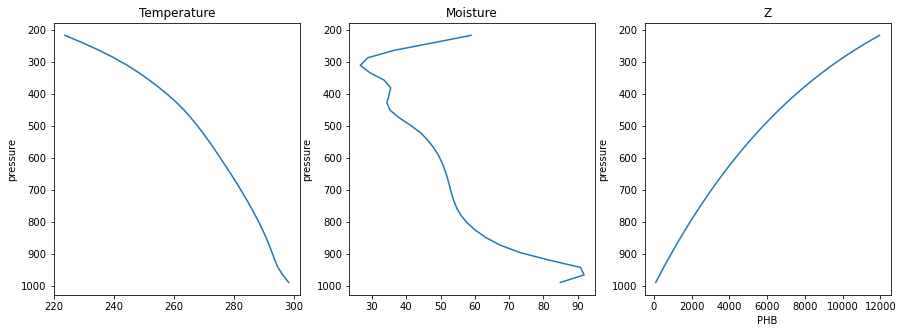

In [83]:
_,ax=plt.subplots(1,3,figsize=(15,5))
t_gms.plot(ax=ax[0],y='pressure',yincrease=False);ax[0].set_title("Temperature")
(100*q_gms/qsat(t_gms,t_gms.pressure)).plot(ax=ax[1],y='pressure',yincrease=False);ax[1].set_title("Moisture")
z_gms.plot(ax=ax[2],y='pressure',yincrease=False);ax[2].set_title("Z")

In [87]:
# On our soundings. 
p_gms = tmean_s.pressure[:,0]
t_gms = tmean_s.sel(distance_from_mtn=slice(-3000,-4900)).mean('distance_from_mtn').assign_coords({'pressure':p_gms}).swap_dims({'eta_level':'pressure'})
q_gms = qmean_s.sel(distance_from_mtn=slice(-3000,-4900)).mean('distance_from_mtn').assign_coords({'pressure':p_gms}).swap_dims({'eta_level':'pressure'})
z_gms = change_coords_etav(hrchannel,hrchannel.PHB[-1,:,0,0].load(),staggered=1).interp_like(p_gms).assign_coords({'pressure':p_gms}).swap_dims({'eta_level':'pressure'})/9.81

t_gms = t_gms[::-1][4:]
q_gms = q_gms[::-1][4:]
z_gms = z_gms[::-1][4:]

print("On WRF 3000-4900 upstream mean sounding : Mh,Ms,Mq = %i, %i, %i J/kg"%M(z_gms,q_gms,t_gms,t_gms.pressure*100))


On WRF 3000-4900 upstream mean sounding : Mh,Ms,Mq = 830, 2760, 1930 J/kg


In [8]:
lmchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/')

lmtmean_s = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.TEMP.days50-200.nc')
lmqmean_s = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.QVAPOR.days50-200.nc')
lmtmean_s   = change_coords_eta(hrchannel,lmtmean_s  ) 
lmqmean_s   = change_coords_eta(hrchannel,lmqmean_s  )

In [20]:
# On our soundings. 
lmp_gms = lmtmean_s.pressure[:,0]
lmt_gms = lmtmean_s.sel(distance_from_mtn=slice(-3000,-4900)).mean('distance_from_mtn').assign_coords({'pressure':lmp_gms}).swap_dims({'eta_level':'pressure'})
lmq_gms = lmqmean_s.sel(distance_from_mtn=slice(-3000,-4900)).mean('distance_from_mtn').assign_coords({'pressure':lmp_gms}).swap_dims({'eta_level':'pressure'})
lmz_gms = change_coords_etav(lmchannel,lmchannel.PHB[-1,:,0,0].load(),staggered=1).interp_like(lmp_gms).assign_coords({'pressure':lmp_gms}).swap_dims({'eta_level':'pressure'})/9.81

lmt_gms = lmt_gms[::-1]
lmq_gms = lmq_gms[::-1]
lmz_gms = lmz_gms[::-1]

print("On WRF 3000-4900 upstream mean sounding : Mh,Ms,Mq = %i, %i, %i J/kg"%M(lmz_gms,lmq_gms,lmt_gms,lmt_gms.pressure*100))


On WRF 3000-4900 upstream mean sounding : Mh,Ms,Mq = 1569, 4228, 2658 J/kg


# Time scale closure : Finding CIN from dry w

In [16]:
wdry_s = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.W.days50-100.nc")
wdry_s=change_coords_eta(hrchannel,wdry_s,staggered=1)
wdry_s=wdry_s.interp_like(tmean_s[:,0]).assign_coords({'pressure':change_coords_eta(hrchannel,hrchannel.PB[-1,:,0,:].load()/100)})

In [20]:
def interppress(wi):
    w=xr.DataArray(np.zeros(wi.shape),coords={'pressure':np.array(wi[:,0].pressure),'distance_from_mtn':wi.distance_from_mtn},dims=['pressure','distance_from_mtn'])
    ref=wi[:,0].swap_dims({'eta_level':'pressure'})
    for i in range(len(w[0])):
        w[:,i] = wi[:,i].swap_dims({'eta_level':'pressure'}).interp_like(ref)
    return w

In [21]:
%time wdry_sp = interppress(wdry_s)

CPU times: user 14.7 s, sys: 0 ns, total: 14.7 s
Wall time: 14.7 s


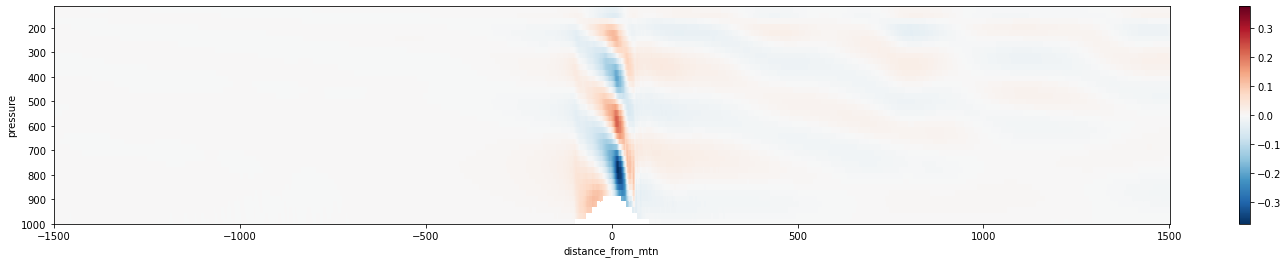

In [35]:
fig,ax=plt.subplots(1,1,figsize=(25,4))
wdry_sp.sel(distance_from_mtn=slice(1500,-1500)).plot(ax=ax,yincrease=False,cmap=plt.cm.RdBu_r)


In [22]:
#compute true deltaT
def interppress_broadcast(ti,tu):
    #given an upstream sounding, interpolate along pressure levels across whole distance_from_mtn dimension
    t=xr.DataArray(np.zeros(ti.shape),coords={'eta_level':np.array(ti[:,0].eta_level),'distance_from_mtn':ti.distance_from_mtn},dims={'eta_level','distance_from_mtn'})
    for i in range(len(ti[0])):
        ref=ti[:,i].swap_dims({'eta_level':'pressure'})
        t[:,i] = np.array(tu.swap_dims({'eta_level':'pressure'}).interp_like(ref))
    return t

deltatmean_s = tmean_s - interppress_broadcast(tmean_s,tmean_s[:,2500])


In [23]:
upstreamZ = change_coords_etav(hrchannel,hrchannel.PHB[-1,:,0,0].load()/9.81,staggered=1).interp_like(tmean_s[:,0])
upstreamT=tmean_s[:,2500:3000].mean('distance_from_mtn')
upstreamdTdz = upstreamT.assign_coords({'z' : upstreamZ/1000}).differentiate('z')


Find the temperature perturbation compared to upstream with: $U\dfrac{d}{dx}\delta T = -w (\Gamma_d-\Gamma_{\text{upstream}}(z))$

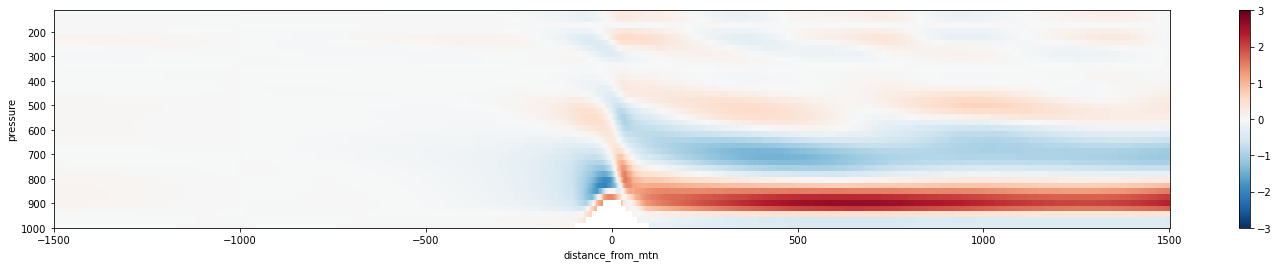

In [24]:
int_wdx = np.cumsum(wdry_s[:,::-1],axis=1)*3000 #(m^2/s)
int_wdx=int_wdx-int_wdx.sel(distance_from_mtn=-1002)
U=10 #m/s
DALR = -9.81/1004
dTdz = DALR - upstreamdTdz/1000
dTdz_2 = -7/1000 - upstreamdTdz/1000


fig,ax=plt.subplots(1,1,figsize=(25,4))
interppress((int_wdx*dTdz_2/U).assign_coords({'pressure':wdry_s.pressure})).sel(distance_from_mtn=slice(-1500,1500)).plot(ax=ax,yincrease=False,vmin=-3,vmax=3,cmap=plt.cm.RdBu_r)

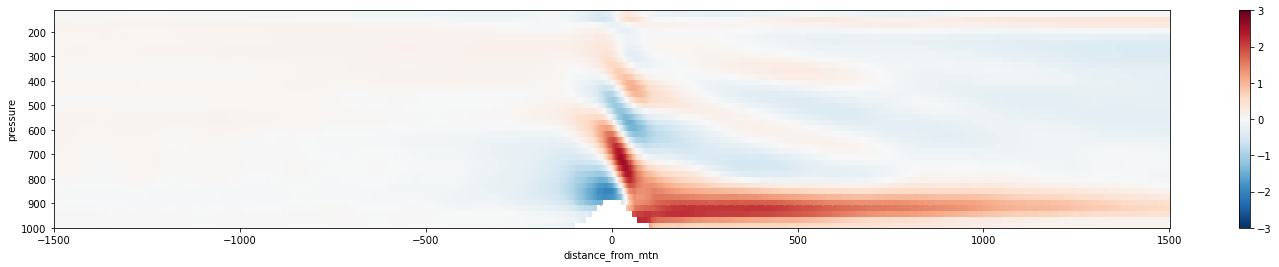

In [200]:
fig,ax=plt.subplots(1,1,figsize=(25,4))
interppress(deltatmean_s.assign_coords({'pressure':wdry_s.pressure})).sel(distance_from_mtn=slice(1500,-1500)).plot(ax=ax,yincrease=False,vmin=-3,vmax=3,cmap=plt.cm.RdBu_r)

Text(0.5, 1.0, 'Temperature - far upstream temperature')

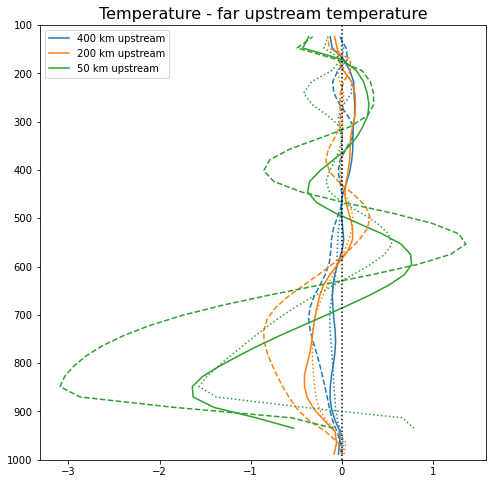

In [202]:
_,ax=plt.subplots(1,1,figsize=(8,8))

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for i,d in enumerate([-400,-200,-50]):
    p=tmean_s.sel(distance_from_mtn=d,method='nearest').pressure.swap_dims({'eta_level':'pressure'})
    ax.plot(deltatmean_s.sel(distance_from_mtn=d,method='nearest'),p,color=colors[i],label="%i km upstream"%(-d))
    ax.plot((int_wdx*dTdz/U).sel(distance_from_mtn=d,method='nearest')  ,p,linestyle='--',color=colors[i])
    ax.plot((int_wdx*dTdz_2/U).sel(distance_from_mtn=d,method='nearest'),p,linestyle=':',color=colors[i])
        
ax.set_ylim(1000,100.)
ax.axvline(0.,linestyle=':',color='k')
ax.legend()
ax.set_title("Temperature - far upstream temperature",fontsize=16)

In [25]:
allZ = change_coords_eta(hrchannel,hrchannel.PHB[-1,:,0,:].load()/9.81,staggered=1).interp_like(tmean_s[:,0])
def integrate(da,coordname,dim):
    return xr.apply_ufunc(np.trapz,da,da[coordname],input_core_dims=[[dim],[dim]])
def find_ffill(coord,dim,threshs):
    #find index where coord value is just under thresh
    return xr.apply_ufunc(lambda x,y : np.searchsorted(x,y)-1,coord,threshs,input_core_dims=[[dim],[]],vectorize=True)

LFC$(x)$ = LFC$_{\mathrm{upstream}} + \dfrac{\delta T(x,\mathrm{LFC}_{\mathrm{upstream}})}{\Gamma_\mathrm{env} - \Gamma_m}$

In [26]:
deltaT=(int_wdx*dTdz_2/U).assign_coords({'z':allZ})
lfclev=4
LFC = 1500+deltaT[lfclev]/(-3.5-upstreamdTdz[lfclev])*1000
LFC=np.maximum(LFC,deltaT.z[0]+1)

dt_lfca = deltaT[find_ffill(deltaT.z,'eta_level',LFC)]
dt_lfcb = deltaT[1+find_ffill(deltaT.z,'eta_level',LFC)]
dt_lfc = (dt_lfca*(LFC-dt_lfca.z) + dt_lfcb*(dt_lfcb.z-LFC))/(dt_lfcb.z-dt_lfca.z)

CIN = (integrate(deltaT.where(deltaT.z<LFC).fillna(0.),'z','eta_level')+(dt_lfca+dt_lfc)/2*(LFC-dt_lfca.z))*9.81/300

In [27]:
LFC2=change_coords_sfc(hrchannel_capecin.isel(Time=slice(200,400)).mean(['Time','south_north']).load()[3])[::-1]

Text(0, 0.5, 'LFC (m)')

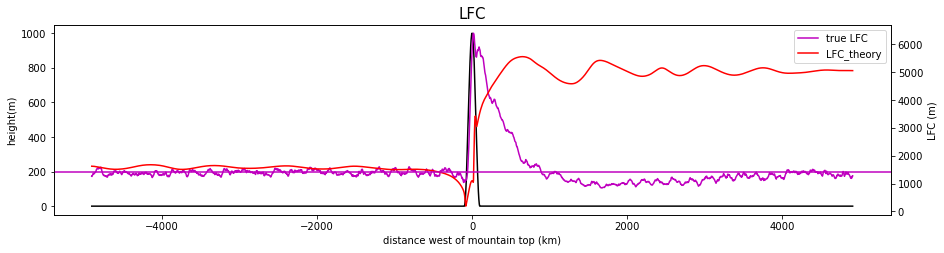

In [34]:
ax,ax2=plotsection(hrhgt,figsize=(15,3.5))
dist=(1635-hrhgt.west_east)*3
ax2.plot(dist ,LFC2[::-1],color='m', label='true LFC')
ax2.plot(dist,LFC[::-1],color='r',label="LFC_theory")

ax2.axhline(LFC2[:1000].mean(),color='m')
ax2.legend()
ax2.set_title("LFC", fontsize=15)
ax2.set_ylabel("LFC (m)")
#ax2.set_ylim(-150.,150)
#ax.set_xlim(-1000,1000)
#ax.set_ylim(-4000.,4000)

In [35]:
deltatmean_sz = deltatmean_s.assign_coords({'z':allZ})[:,::-1]
#LFC2 = hrchannel_capecin.isel(Time=slice(200,400)).mean(['Time','south_north']).load()[3][::-1]#1500+deltatmean_sz[lfclev]/(-3.5-upstreamdTdz[lfclev])*1000
LFC2=np.maximum(LFC2,deltatmean_sz.z[0]+1)

dt_lfca2 = deltatmean_sz[find_ffill(deltatmean_sz.z,'eta_level',LFC2)]
dt_lfcb2 = deltatmean_sz[1+find_ffill(deltatmean_sz.z,'eta_level',LFC2)]
dt_lfc2 = (dt_lfca2*(LFC2-dt_lfca2.z) + dt_lfcb2*(dt_lfcb2.z-LFC2))/(dt_lfcb2.z-dt_lfca2.z)

CIN2 = (integrate(deltatmean_sz.where(deltatmean_sz.z<LFC2).fillna(0.),'z','eta_level')+(dt_lfca2+dt_lfc2)/2*(LFC2-dt_lfca2.z))*9.81/300

In [36]:
hrchannel_cin = hrchannel_capecin.isel(Time=slice(200,400)).mean(['Time','south_north']).persist()[1]

In [37]:
def calc_cin(T,q,plevs,lev=0):
    P = units.hPa * np.array(plevs)
    Tups = units.degK*np.array(T)
    qups = np.array(q)
    idxcape = np.argmax(~np.isnan(np.array(T)))+lev
    Tdups = mpcalc.dewpoint_from_specific_humidity(qups,Tups,P)
    profups = mpcalc.parcel_profile(P[idxcape:], Tups[idxcape], Tdups[idxcape]).to('degC')
    return mpcalc.cape_cin(P[idxcape:], Tups[idxcape:], Tdups[idxcape:],profups)[1]/units("J/kg")

In [38]:
%%time
n=8
cin_fromskewt_s=np.zeros(3270//n)
for i in range(0,3270//n):
    try :
        cin_fromskewt_s[i] = calc_cin(tmean_s.isel(distance_from_mtn=i*n),qmean_s.isel(distance_from_mtn=i*n),qmean_s.pressure.isel(distance_from_mtn=i*n))
    except RuntimeError:
        cin_fromskewt_s[i] = 0
cin_fromskewt_s = np.array(cin_fromskewt_s)

CPU times: user 1min 1s, sys: 92.3 ms, total: 1min 2s
Wall time: 1min 2s


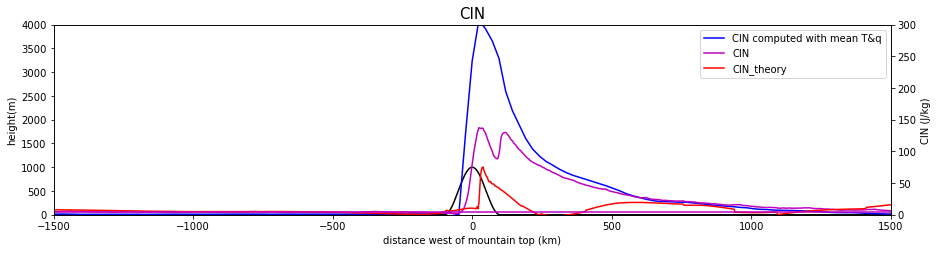

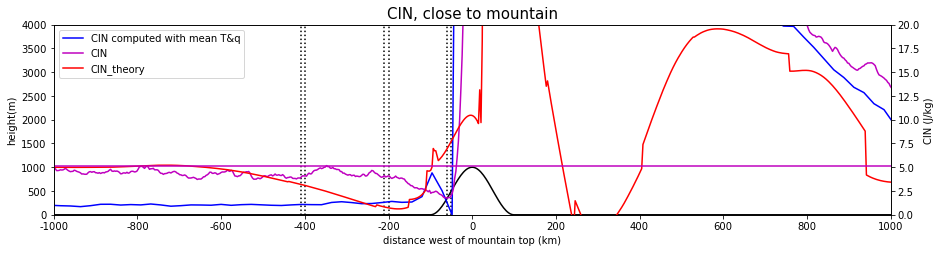

In [42]:
ax,ax2=plotsection(hrhgt,figsize=(15,3.5))
dist=(1635-hrhgt.west_east)*3

dist2=(1635//n-np.arange(3270//n))*3*n
ax2.plot(dist2 ,-cin_fromskewt_s,color='blue', label='CIN computed with mean T&q')
ax2.plot(dist,hrchannel_cin,color='m',label="CIN")
ax2.plot(dist[::-1],CIN+5,color='r',label="CIN_theory")
#ax2.plot(dist[::-1],CIN2+5,color='r',linestyle='--',label="CIN_theory")
ax2.axhline(hrchannel_cin[2000:3000].mean(),color='m')
ax2.legend()
ax2.set_title("CIN", fontsize=15)
ax2.set_ylabel("CIN (J/kg)")
ax2.set_ylim(0.,300)
ax.set_xlim(-1500.,1500)
ax.set_ylim(0.,4000)

ax,ax2=plotsection(hrhgt,figsize=(15,3.5))
dist=(1635-hrhgt.west_east)*3

ax2.plot(dist2 ,-cin_fromskewt_s,color='blue', label='CIN computed with mean T&q')
ax2.plot(dist,hrchannel_cin,color='m',label="CIN")
ax2.plot(dist[::-1],CIN+5,color='r',label="CIN_theory")
#ax2.plot(dist[::-1],CIN2+5,color='r',linestyle='--',label="CIN_theory")
ax2.axhline(hrchannel_cin[2000:3000].mean(),color='m')
ax2.legend()

ax2.set_title("CIN, close to mountain", fontsize=15)
ax2.set_ylim(0.,20)
ax2.set_ylabel("CIN (J/kg)")
ax.set_xlim(-1000,1000)
ax.set_ylim(0.,4000)

xticks=np.arange(-1000,1001,200)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks);None
for d in [-50,-60,-200,-210,-400,-410]:
    ax.axvline(d,color='k',linestyle=':')

 CAPE = 1066.6 J/kg
 CAPE = 953.2 J/kg
 CAPE = 1066.6 J/kg
 CAPE = 196.6 J/kg
 CAPE = 1066.6 J/kg
 CAPE = 339.8 J/kg
 CAPE = 1066.6 J/kg
 CAPE = 1338.8 J/kg
 CAPE = 1066.6 J/kg
 CAPE = 1715.9 J/kg


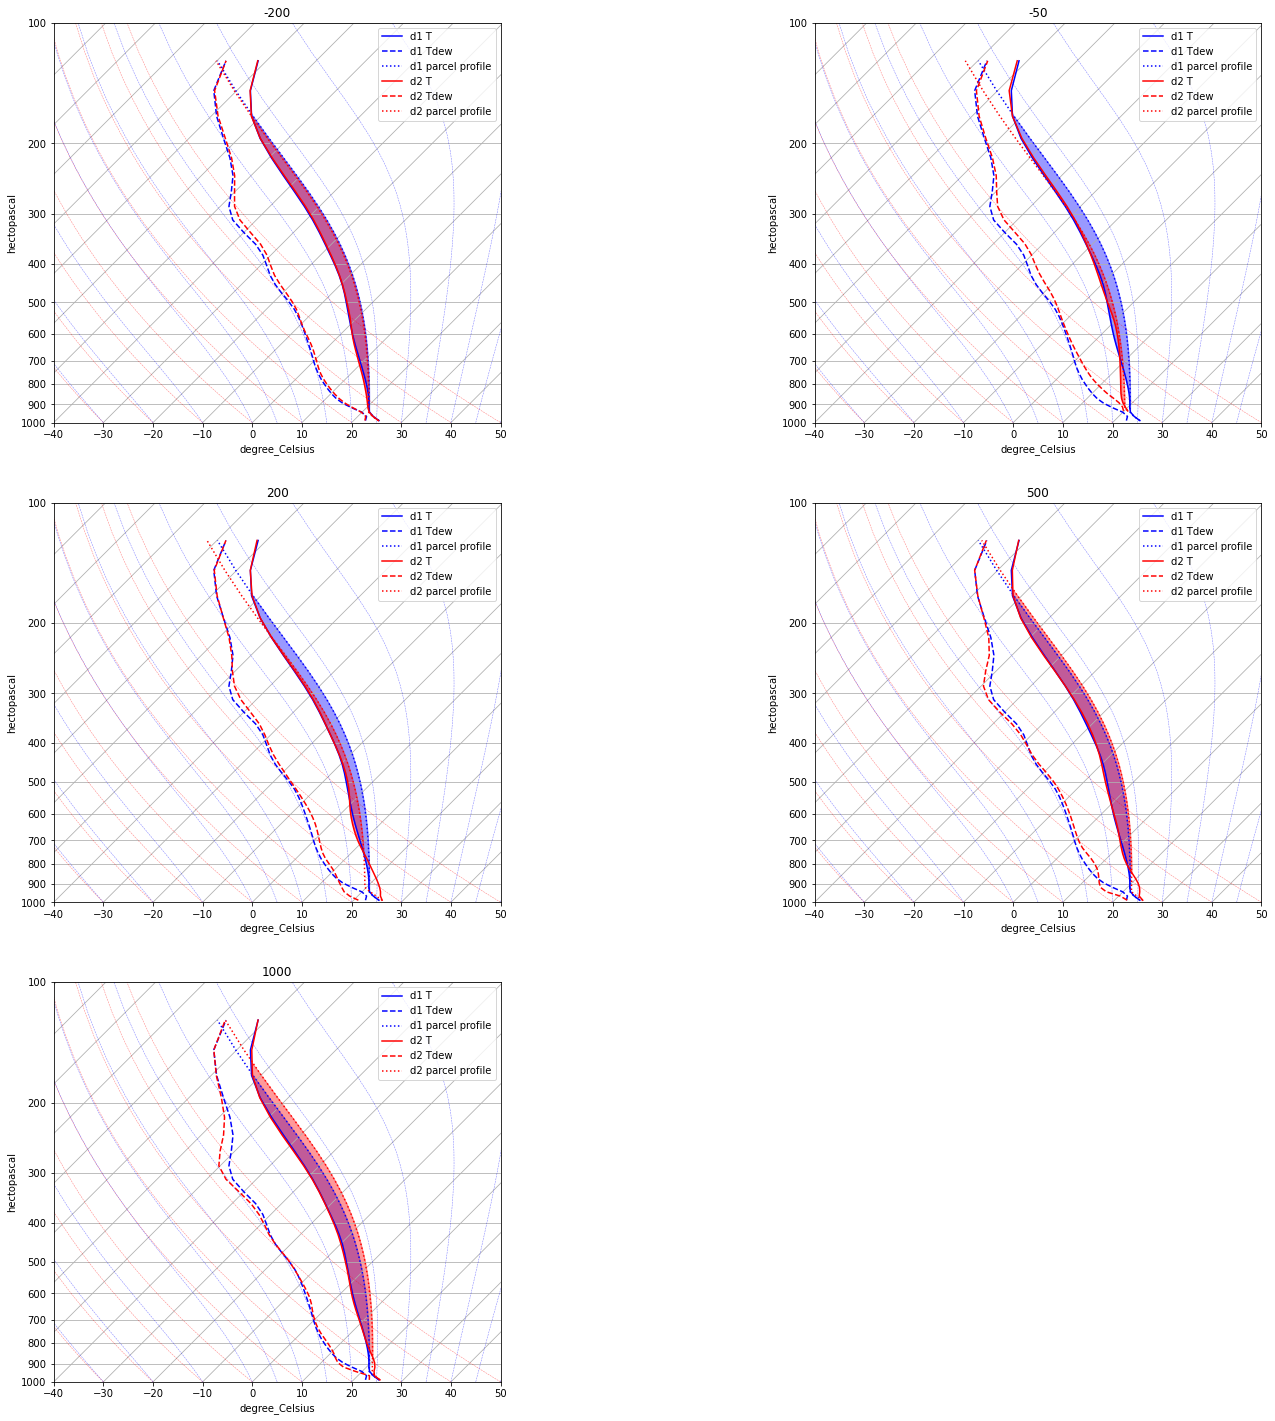

In [229]:
fig = plt.figure(figsize=(25,25))

for i,(d1,d2) in enumerate(zip([-3000]*5,[-200,-50,200,500,1000])):
    skew = SkewT(fig,subplot=(3,2,i+1), rotation=45)
    plot_skewt(tmean_s.sel(distance_from_mtn=d1,method='nearest'),qmean_s.sel(distance_from_mtn=d1,method='nearest'),np.array(qmean_s.sel(distance_from_mtn=d1,method='nearest').pressure),skew,"blue",'d1')
    plot_skewt(tmean_s.sel(distance_from_mtn=d2,method='nearest'),qmean_s.sel(distance_from_mtn=d2,method='nearest'),np.array(qmean_s.sel(distance_from_mtn=d2,method='nearest').pressure),skew,"red",'d2')
    skew.ax.set_title(d2)


# Linear & nonlinear theory for dry w

In [256]:
from scipy.signal import hilbert
from scipy.integrate import cumtrapz
import scipy.linalg as spl
def nonlinear_mountain_wave(h,N,U,x,z):
    """z must be two-dimensional here, dimensions=(eta_level,distance_from_mtn)"""
    z2=np.array(z).transpose()[::-1]
    f_L = -np.imag(hilbert(h))
    l=N/U
    H = h+1.j*f_L
    niter=20
    for i in range(niter):
        H = -1j*np.exp(-1j*l*h)*(np.imag(hilbert(np.real(H*np.exp(1j*l*h))))+1j*np.imag(hilbert(np.imag(H*np.exp(1j*l*h)))))
    f=np.imag(H)
    delta = h[:,None]*np.cos(l*(z2-h[:,None]))+f[:,None]*np.sin(l*(z2-h[:,None]))
    w=U*np.gradient(delta,x,axis=0)
    return xr.DataArray(w[::-1].transpose(),coords={'eta_level':z.eta_level,'distance_from_mtn':z.distance_from_mtn},dims={'eta_level','distance_from_mtn'})

def k_vector(Nx,width):
    if Nx % 2 == 0:
        k = np.array(list(range(0, Nx // 2)) + [0] + list(range(-Nx // 2 + 1,0)))
    else:
        k = np.array(list(range(0,(Nx - 1) / 2)) + [0] + list(range(-(Nx - 1) / 2, 0)))
    k = 2 * np.pi / width *k
    return k

def m_exponent(k,N,U):
    return - np.sign(k**2-N**2/U**2)**((np.sign(k+1e-4*k[1])+1)/2) * np.sqrt(k**2-N**2/U**2+0.j) #1e-4*k[1] it there to avoid fractional powers

def linear_mountain_wave(h,N,U,x,z):
    k=k_vector(len(x),x[-1])
    h_hat = np.fft.fft(h)
    w_hat = 1j*k[:,None]*U*h_hat[:,None]*np.exp( m_exponent(k[:,None],N,U)  *  z[None,:]) 
    w=xr.DataArray(np.real(np.fft.ifft(w_hat,axis=0)),coords={'x':x,'z':z},dims={'x':x,'z':z})
    return w

In [243]:
U=10
N=0.009

x = np.array(wdrymean_s.distance_from_mtn)[::-1]
Nx=len(x)
width=1000*(x[-1]-x[0])
z=np.array(hrchannel.PHB[0,:,0,0]/9.81)
Nz=len(z)


In [244]:
w_linear  = linear_mountain_wave(np.array(hrhgt[::-1]),N,U,1000*(x-x[0]),z)
w_linear_s=xr.DataArray(np.array(w_linear)[::-1].transpose(),coords={'eta_level':wdrymean_s.eta_level,'distance_from_mtn':wdrymean_s.distance_from_mtn},dims={'eta_level','distance_from_mtn'})


In [257]:
w_nonlinear_s = nonlinear_mountain_wave(np.array(hrhgt[::-1]),N,U,1000*(x-x[0]),change_coords_eta(hrchannel,hrchannel.PHB[0,:,0],staggered=True)/9.81)


(-1500.0, 1500.0)

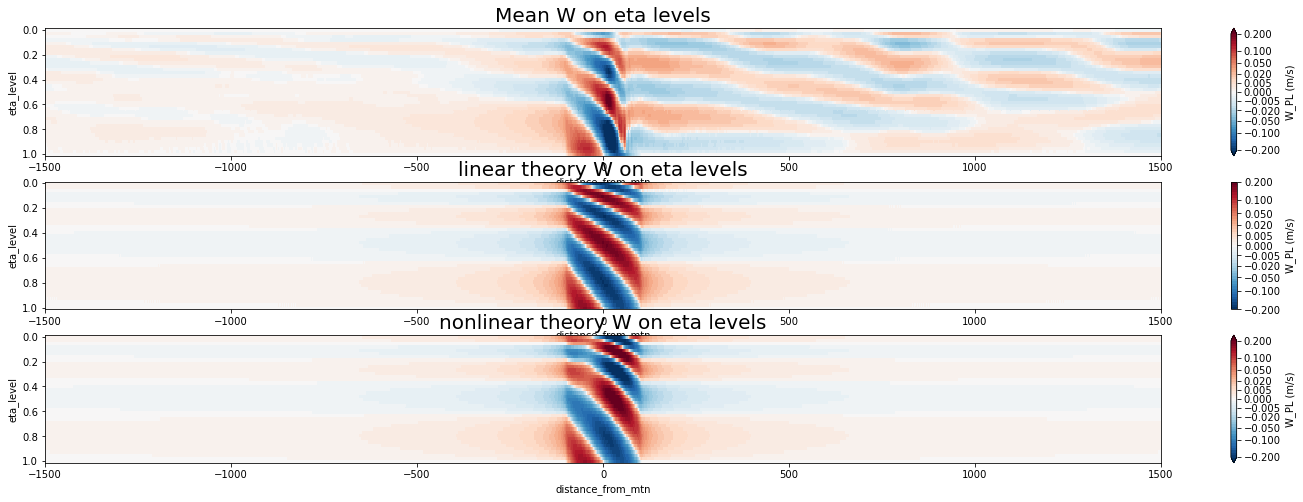

In [259]:
fig,ax=plt.subplots(3,1,figsize=(25,8))
wmax=0.2
wlevs=f(np.linspace(-wmax**(1/2),wmax**(1/2),50))
wticks=[-0.2,-0.1,-0.05,-0.02,-0.005,0,0.005,0.02,0.05,0.1,0.2]

wdrymean_s.plot(ax=ax[0],yincrease=False, levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':'W_PL (m/s)'})
ax[0].set_title("Mean W on eta levels",fontsize=20)
ax[0].set_xlim(-1500,1500)

w_linear_s.plot(ax=ax[1],yincrease=False, levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':'W_PL (m/s)'})
ax[1].set_title("linear theory W on eta levels",fontsize=20)
ax[1].set_xlim(-1500,1500)

w_nonlinear_s.plot(ax=ax[2],yincrease=False, levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':'W_PL (m/s)'})
ax[2].set_title("nonlinear theory W on eta levels",fontsize=20)
ax[2].set_xlim(-1500,1500)

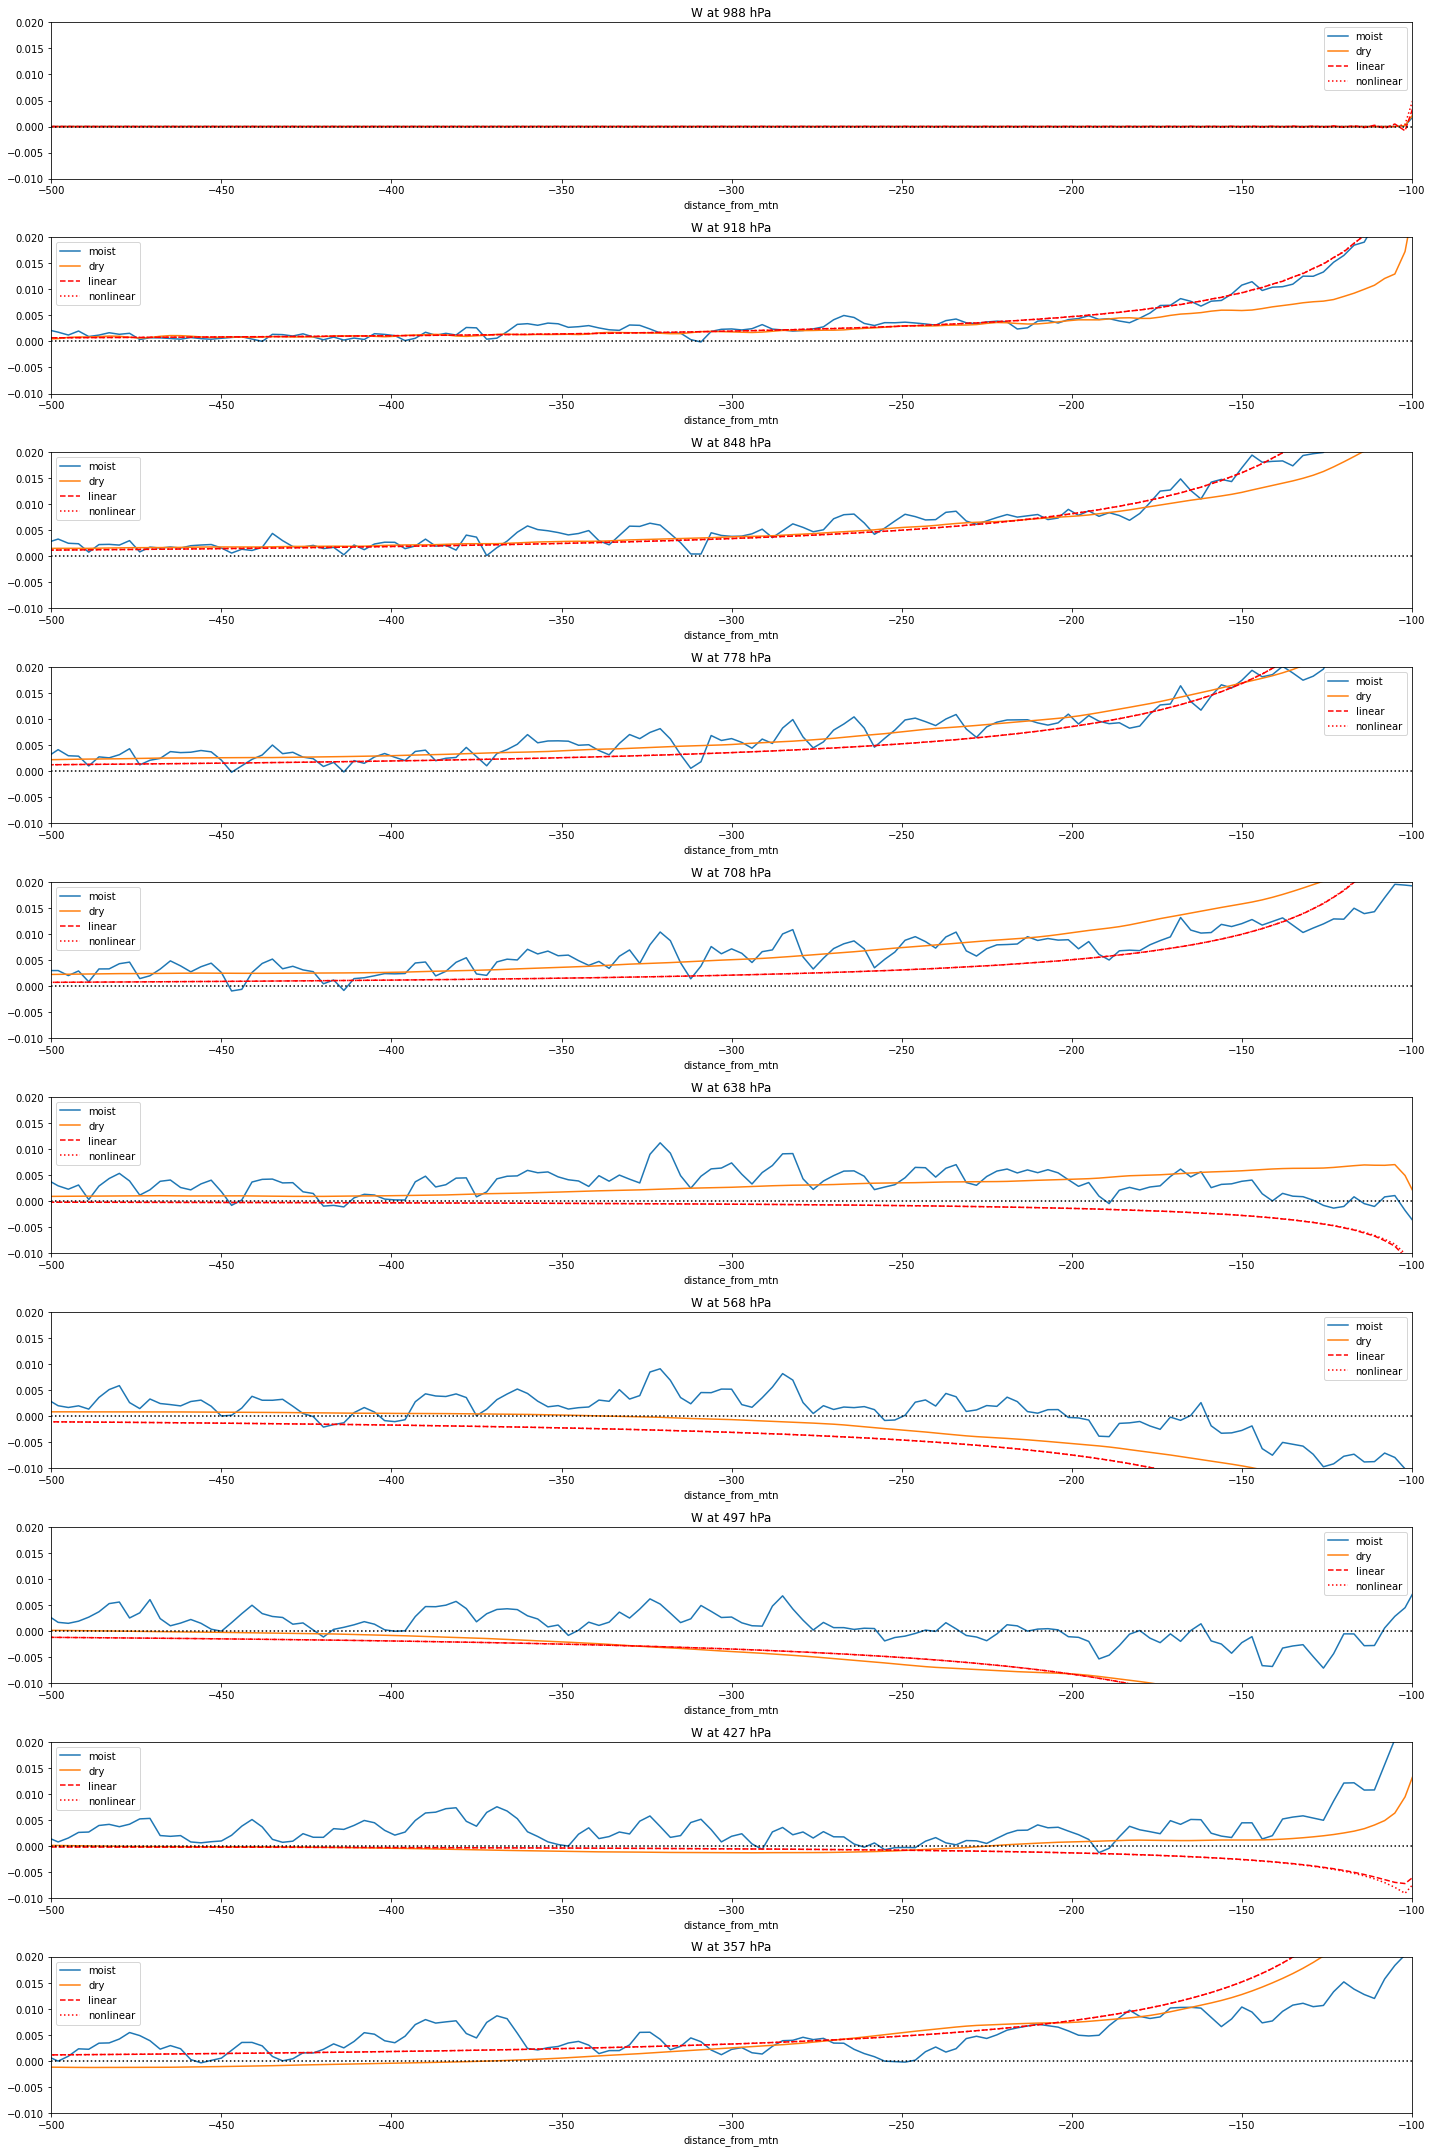

In [260]:
n=30;q=3
fig,ax=plt.subplots(n//q,1,figsize=(20,3*n//q))
for i in range(0,n//q):
    wmean_s.isel(eta_level=i*q).plot(ax=ax[i],label='moist')
    wdrymean_s.isel(eta_level=i*q).plot(ax=ax[i],label='dry')
    w_linear_s.isel(eta_level=i*q).plot(ax=ax[i],color='r',linestyle='--',label='linear')
    w_nonlinear_s.isel(eta_level=i*q).plot(ax=ax[i],color='r',linestyle=':',label='nonlinear')
    ax[i].set_title("W at %i hPa"%(hrchannel.PB[0,i*q,0,0]/100))
    ax[i].legend()
    ax[i].axhline(0.,color='k',linestyle=':')
    ax[i].set_xlim(-500,-100)
    ax[i].set_ylim(-0.01,0.02)
fig.tight_layout()

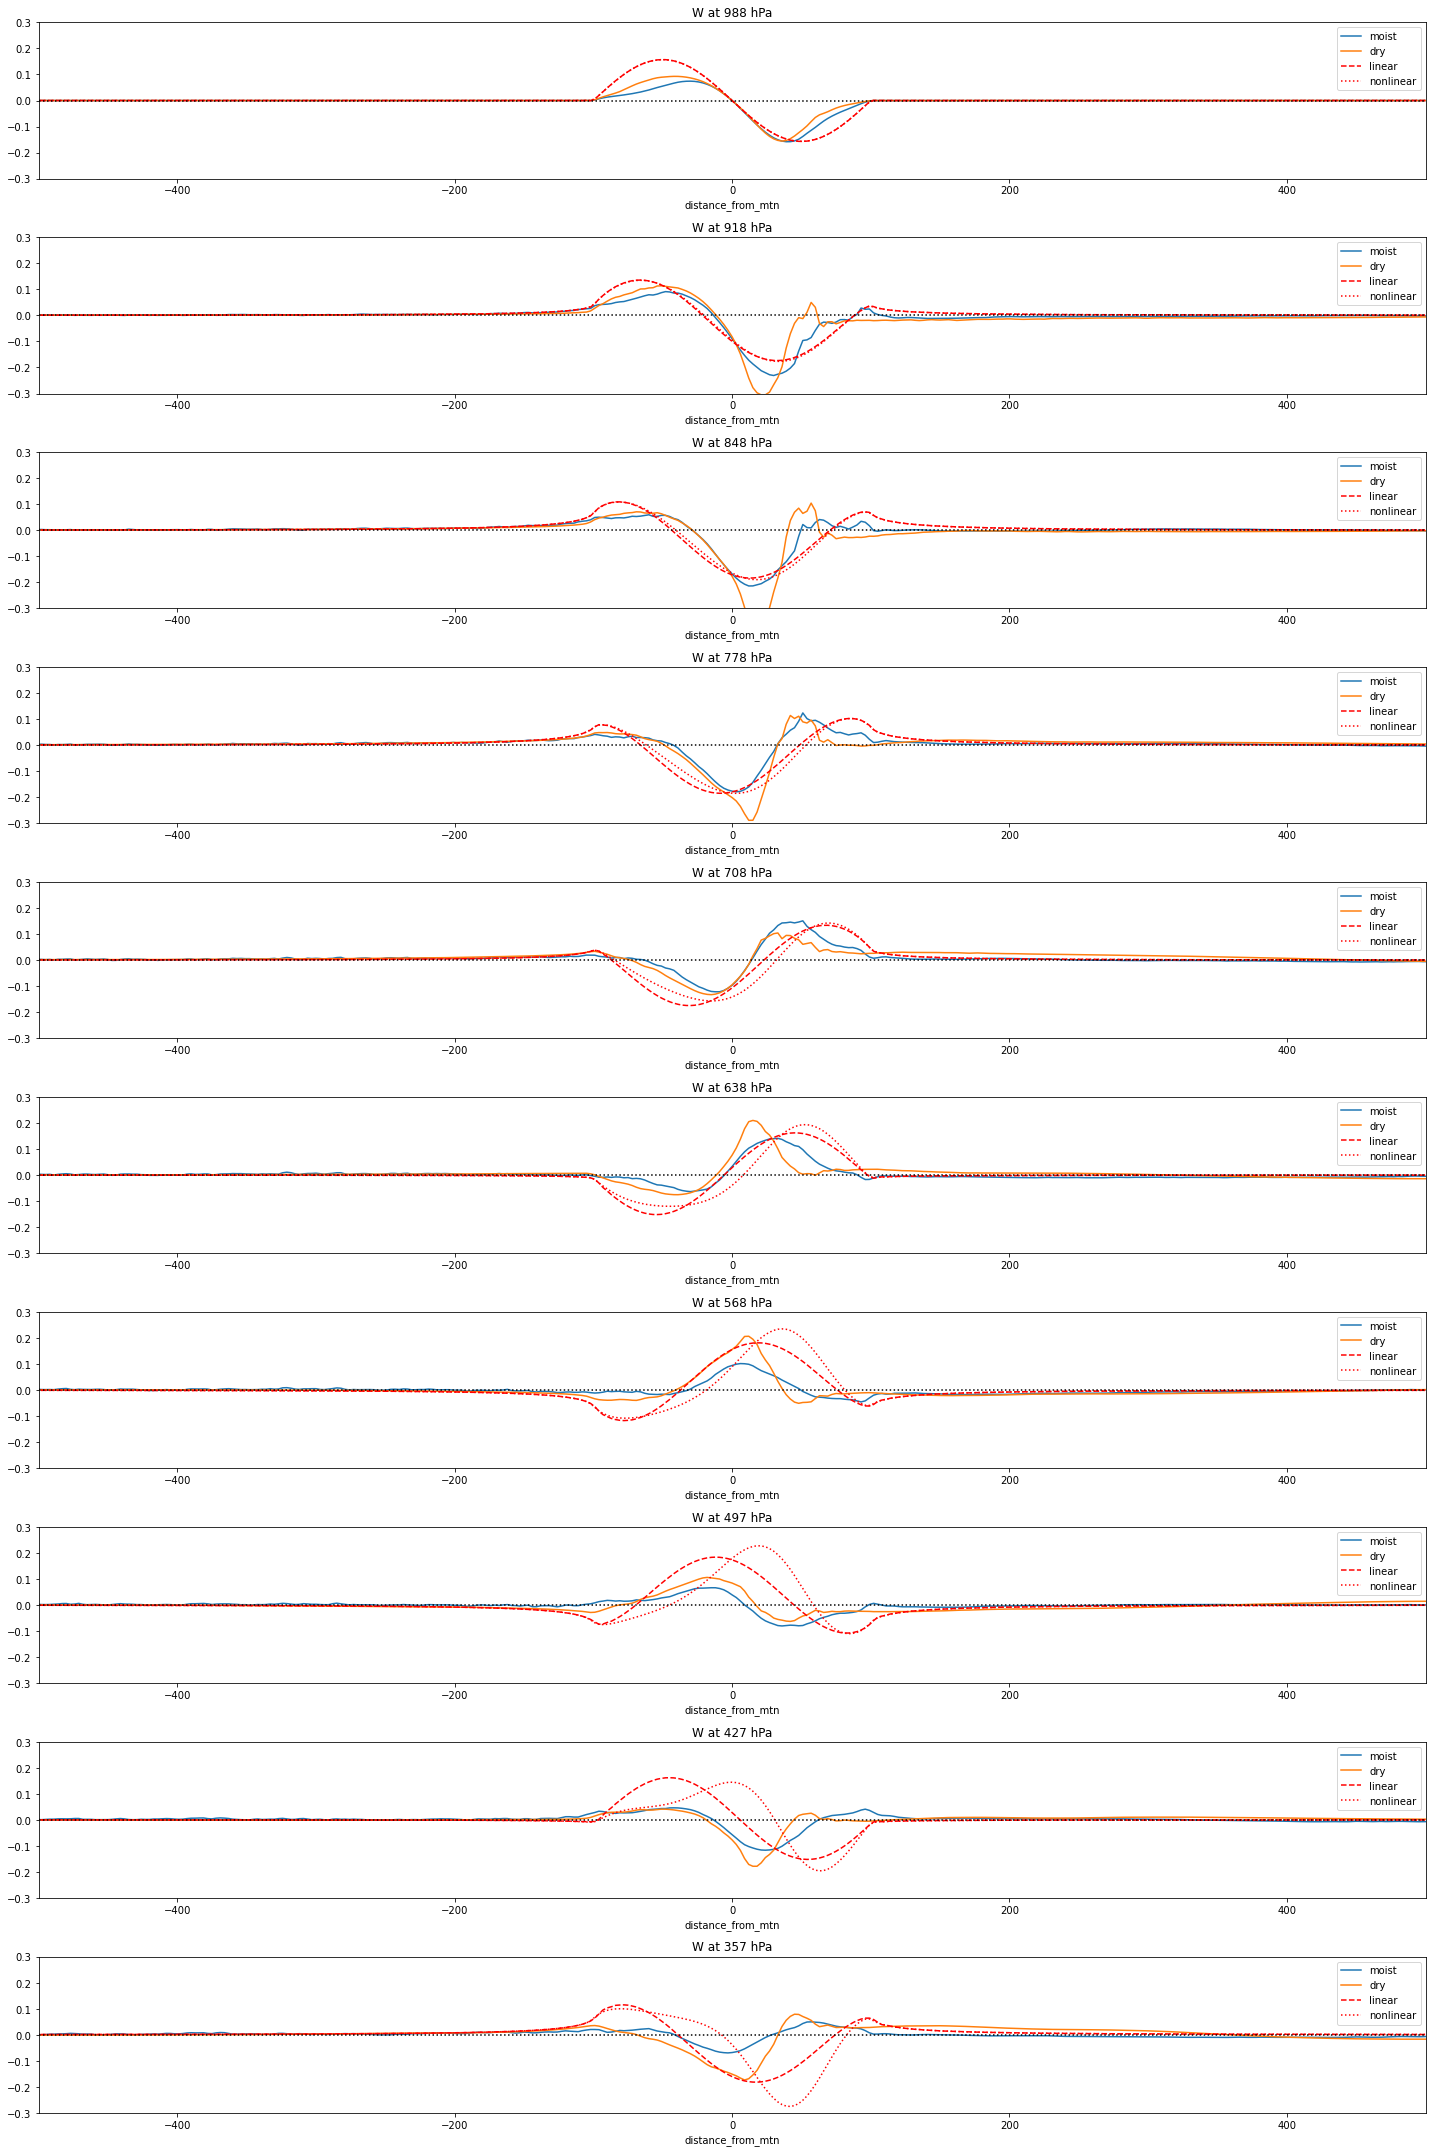

In [261]:
n=30;q=3
fig,ax=plt.subplots(n//q,1,figsize=(20,3*n//q))
for i in range(0,n//q):
    wmean_s.isel(eta_level=i*q).plot(ax=ax[i],label='moist')
    wdrymean_s.isel(eta_level=i*q).plot(ax=ax[i],label='dry')
    w_linear_s.isel(eta_level=i*q).plot(ax=ax[i],color='r',linestyle='--',label='linear')
    w_nonlinear_s.isel(eta_level=i*q).plot(ax=ax[i],color='r',linestyle=':',label='nonlinear')
    ax[i].set_xlim(-500,500)
    ax[i].set_title("W at %i hPa"%(hrchannel.PB[0,i*q,0,0]/100))
    ax[i].legend()
    ax[i].axhline(0.,color='k',linestyle=':')
    ax[i].set_ylim(-0.3,0.3)
fig.tight_layout()

In [102]:
def interp_eta_to_pressure(ds,var,staggered=1):
    """Make sure eta_level is the first dimension"""
    plevs= np.arange(125.,990.,20.)
    rep=np.zeros((len(plevs),len(var[0])))
    PB_rev = np.array(ds.PB[0,:,0])[::-1]
    var_rev=np.array(var)[::-1]
    if staggered:
        i=0
        ZNW = np.array(ds.ZNW[0])[::-1]
        ZNU=  np.array(ds.ZNU[0])[::-1]
        for i in range(len(var[0])):
            PB_rev_stag = np.interp(ZNW,ZNU,PB_rev[:,i])
            rep[:,i]=np.interp(plevs*100,PB_rev_stag,var_rev[:,i])
            rep[plevs*100>PB_rev_stag[-1],i]=np.nan
    else:
        for i in range(len(var[0])):
            rep[:,i]=np.interp(plevs*100,PB_rev[:,i],var_rev[:,i])
    return xr.DataArray(rep[::-1],coords={'pressure':plevs[::-1],'distance_from_mtn':var.distance_from_mtn},dims={'pressure','distance_from_mtn'})

In [262]:
wdrymean_p = interp_eta_to_pressure(hrchannel,wdrymean_s)
w_linear_p = interp_eta_to_pressure(hrchannel,w_linear_s)
w_nonlinear_p = interp_eta_to_pressure(hrchannel,w_nonlinear_s)


(-1500.0, 1500.0)

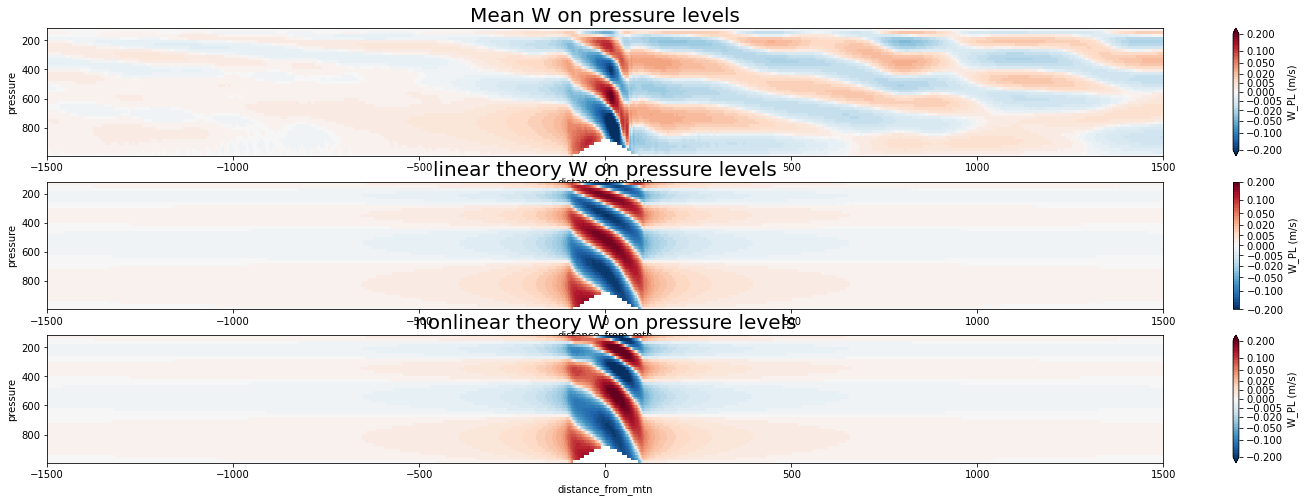

In [263]:
fig,ax=plt.subplots(3,1,figsize=(25,8))
wmax=0.2
wlevs=f(np.linspace(-wmax**(1/2),wmax**(1/2),50))
wticks=[-0.2,-0.1,-0.05,-0.02,-0.005,0,0.005,0.02,0.05,0.1,0.2]

wdrymean_p.plot(ax=ax[0],yincrease=False, levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':'W_PL (m/s)'})
ax[0].set_title("Mean W on pressure levels",fontsize=20)
ax[0].set_xlim(-1500,1500)

w_linear_p.plot(ax=ax[1],yincrease=False, levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':'W_PL (m/s)'})
ax[1].set_title("linear theory W on pressure levels",fontsize=20)
ax[1].set_xlim(-1500,1500)

w_nonlinear_p.plot(ax=ax[2],yincrease=False, levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':'W_PL (m/s)'})
ax[2].set_title("nonlinear theory W on pressure levels",fontsize=20)
ax[2].set_xlim(-1500,1500)

In [196]:
wmean_z = wmean_s.assign_coords({'z':('eta_level',z)}).swap_dims({'eta_level':'z'})
wdrymean_z = wdrymean_s.assign_coords({'z':('eta_level',z)}).swap_dims({'eta_level':'z'})
w_linear_z = w_linear_s.assign_coords({'z':('eta_level',z)}).swap_dims({'eta_level':'z'})


In [204]:
from orographicPrecipitation.smith_lm import HwCw
from orographicPrecipitation.precip_extremes_scaling import moist_adiabatic_lapse_rate

def smith_theory(w):
    ts=np.array([300.])
    ps=np.array([100000.])
    gamma_m = moist_adiabatic_lapse_rate(ts,ps,'era')
    gamma = 0.8*gamma_m
    Hw,Cw = HwCw(ts,ps,gamma)
    Cw/=5
    tau_c=2000.
    tau_f=2000.
    P0=4.5 #mm/day
    
    S = Cw/Hw * (w*np.exp(-w.z/Hw)).integrate('z')
    S=np.array(S)[::-1]
    P=np.maximum(P0+86400*np.real(np.fft.ifft(np.fft.fft(S)/(1+1j*U*k*tau_c)/(1+1j*U*k*tau_f))),0.)
    return xr.DataArray(P[::-1],coords={'distance_from_mtn':w.distance_from_mtn},dims={'distance_from_mtn'})

In [205]:
#Smith linear theory
P_linear=smith_theory(w_linear_z)
P_dry=smith_theory(wdrymean_z)
P_moist=smith_theory(wmean_z)

In [206]:
hrpr=change_coords_sfc(hrchannelprecip[200:800].mean(['Time','south_north']))

Text(0.5, 1.0, "Precip as generated by Smith's linear model, with different W")

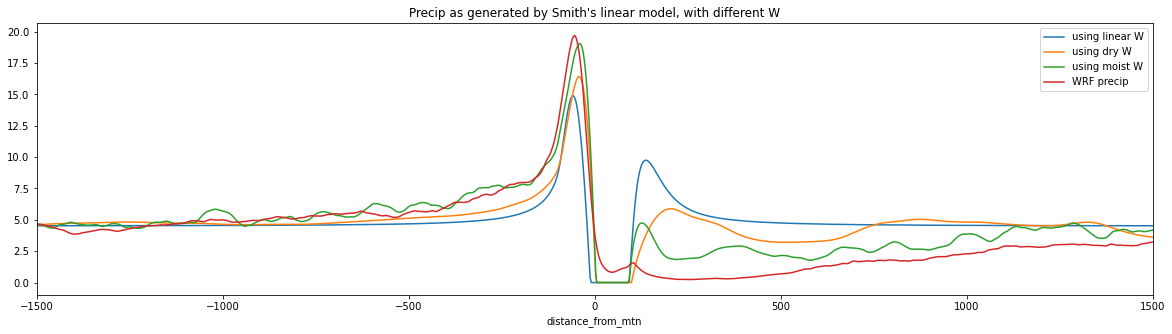

In [209]:
plt.figure(figsize=(20,5))
P_linear.plot(label='using linear W')
P_dry.plot(label='using dry W')
P_moist.plot(label='using moist W')
hrpr.plot(label='WRF precip')
plt.xlim(-1500,1500)
plt.legend()
plt.title("Precip as generated by Smith's linear model, with different W")

# TKE in the PBL (for Mapes convective closure)

In [338]:
%time tkepbl = change_coords_eta(hrchannel,hrchannel.TKE_PBL[200:,:,0,:].mean('Time').load())

CPU times: user 1.68 s, sys: 3.31 s, total: 4.99 s
Wall time: 6min 20s


In [340]:
tkepbl.to_netcdf("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.tke_pbl.days50-200.nc")

(0.0, 0.3)

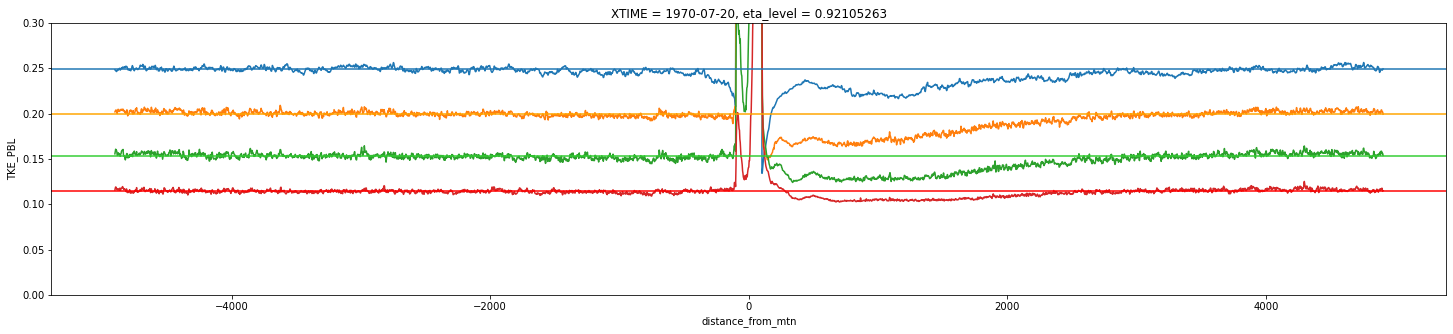

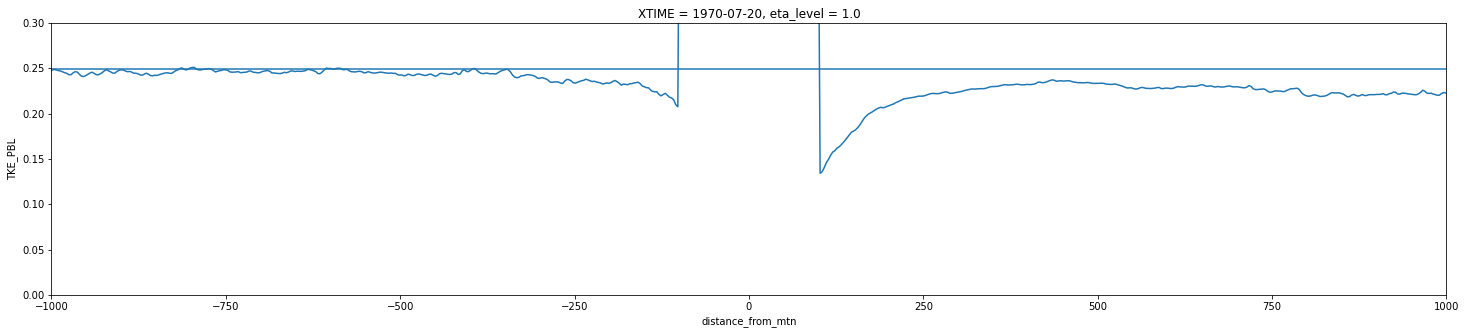

In [342]:
plt.figure(figsize=(25,5))
tkepbl[0].plot()
tkepbl[1].plot()
tkepbl[2].plot()
tkepbl[3].plot()

plt.axhline(tkepbl[0][2000:3000].mean())
plt.axhline(tkepbl[1][2000:3000].mean(),color='orange')
plt.axhline(tkepbl[2][2000:3000].mean(),color='limegreen')
plt.axhline(tkepbl[3][2000:3000].mean(),color='red')

plt.ylim(0.,0.3)

plt.figure(figsize=(25,5))
tkepbl[0].plot()
plt.axhline(tkepbl[0][2000:3000].mean())
plt.xlim(-1000,1000)
plt.ylim(0.,0.3)

# w dh/dp

In [349]:
Cp=1004.
Lv=2.26e6
g=9.81

h = Cp*tmean_p.sel(distance_from_mtn=slice(-3000,-4000)).mean('distance_from_mtn') + g*zmean_p.sel(distance_from_mtn=slice(-3000,-4000)).mean('distance_from_mtn') + Lv*qmean_p.sel(distance_from_mtn=slice(-3000,-4000)).mean('distance_from_mtn')

Qdry=pressure_mean(omegamean_p*h.differentiate("pressure",edge_order=2)/100.)

(-1000.0, 1000.0)

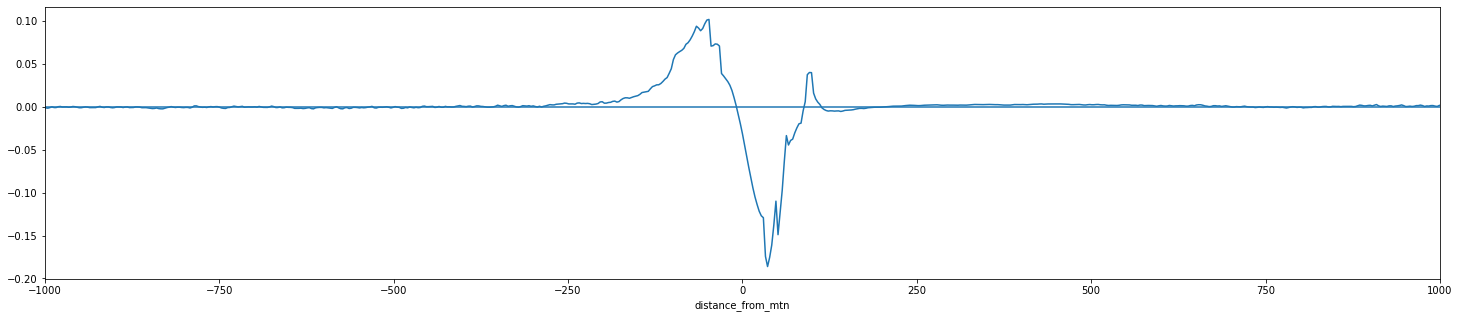

In [355]:
plt.figure(figsize=(25,5))
Qdry.plot()
plt.axhline(Qdry[2000:3000].mean())
plt.xlim(-1000,1000)

# old stuff

In [68]:
qmean_p = change_coords_pl(hrchannel_p,qmean)[1:-4]
tmean_p = change_coords_pl(hrchannel_p,tmean)[1:-4]

In [42]:
-b1_p.integrate('pressure')/750

<xarray.DataArray ()>
array(0.37250808)

In [36]:
a1_p = a1.interp_like(qmean_p,kwargs={"fill_value": "extrapolate"})
b1_p = b1.interp_like(qmean_p,kwargs={"fill_value": "extrapolate"})

In [40]:
qdev=qmean_p-qmean_p.sel(distance_from_mtn=slice(-3000,-4000)).mean('distance_from_mtn')

In [43]:
q1 = qdev.integrate('pressure')/b1_p.integrate('pressure')

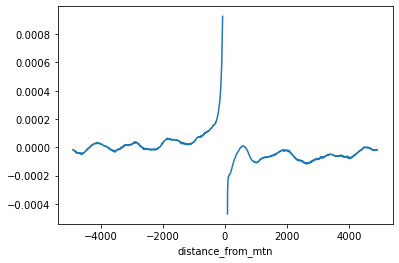

In [45]:
q1.plot()

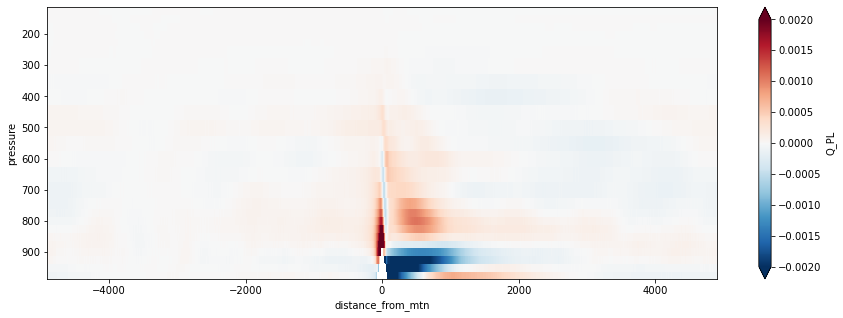

In [52]:
plt.figure(figsize=(15,5))
qdev.plot(yincrease=False,vmin=-0.002,vmax=0.002,cmap=plt.cm.RdBu_r)

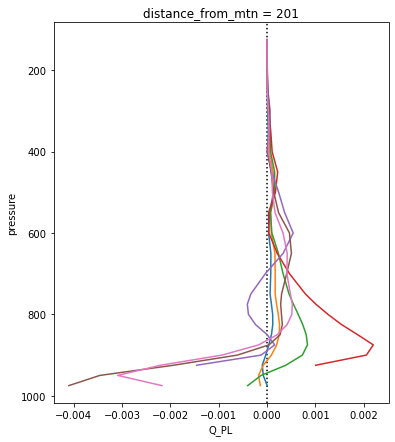

In [61]:
plt.figure(figsize=(6,7))
plt.axvline(0.,linestyle=':',color='k')
qdev.sel(distance_from_mtn=-500,method='nearest').plot(y='pressure',yincrease=False)
qdev.sel(distance_from_mtn=-200,method='nearest').plot(y='pressure',yincrease=False)
qdev.sel(distance_from_mtn=-100,method='nearest').plot(y='pressure',yincrease=False)
qdev.sel(distance_from_mtn=-50,method='nearest').plot(y='pressure',yincrease=False)
qdev.sel(distance_from_mtn=50,method='nearest').plot(y='pressure',yincrease=False)
qdev.sel(distance_from_mtn=100,method='nearest').plot(y='pressure',yincrease=False)
qdev.sel(distance_from_mtn=200,method='nearest').plot(y='pressure',yincrease=False)

In [109]:
def calc_cape(T,q,plevs,lev=0):
    P = plevs* units.hPa
    Tups = units.degK*np.array(T)
    qups = np.array(q)
    
    maxcape = np.argmax(~np.isnan(np.array(T)))+lev
    Tdups = mpcalc.dewpoint_from_specific_humidity(qups,Tups,P)
    profups = mpcalc.parcel_profile(P[maxcape:], Tups[maxcape], Tdups[maxcape]).to('degC')
    return mpcalc.cape_cin(P[maxcape:], Tups[maxcape:], Tdups[maxcape:],profups)[0]/units("J/kg")

%time calc_cape(tmean_p.sel(distance_from_mtn=d1,method='nearest'),qmean_p.sel(distance_from_mtn=d1,method='nearest'),plevs[1:-4])
    

CPU times: user 174 ms, sys: 0 ns, total: 174 ms
Wall time: 172 ms


9.294718217438186 <Unit('dimensionless')>

In [104]:
%%time
n=8
cape_fromskewt=np.zeros(3270//n)
for i in range(0,3270//n):
    try :
        cape_fromskewt[i] = calc_cape(tmean_p.isel(distance_from_mtn=i*n),qmean_p.isel(distance_from_mtn=i*n),plevs[1:-4])
    except RuntimeError:
        cape_fromskewt[i] = 0
cape_fromskewt = np.array(cape_fromskewt)

CPU times: user 1min 5s, sys: 19.3 ms, total: 1min 5s
Wall time: 1min 5s


In [110]:
%%time
n=8
cape_fromskewt950=np.zeros(3270//n)
for i in range(0,3270//n):
    try :
        cape_fromskewt950[i] = calc_cape(tmean_p.isel(distance_from_mtn=i*n),qmean_p.isel(distance_from_mtn=i*n),plevs[1:-4],lev=1)
    except RuntimeError:
        cape_fromskewt950[i] = 0
cape_fromskewt950 = np.array(cape_fromskewt950)

CPU times: user 54.4 s, sys: 87.9 ms, total: 54.5 s
Wall time: 54.5 s


In [150]:
%%time
n=8
cape_fromskewt_q=np.zeros(3270//n)
for i in range(0,3270//n):
    try :
        cape_fromskewt_q[i] = calc_cape(tmean_p.sel(distance_from_mtn=-3000,method='nearest'),qmean_p.sel(distance_from_mtn=-3000,method='nearest')+dq_virtual.isel(distance_from_mtn=i*n),plevs[1:-4])
    except RuntimeError:
        cape_fromskewt_q[i] = 0
cape_fromskewt_q = np.array(cape_fromskewt_q)

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/metpy/calc/thermo.py:828: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/pint/numpy_func.py:289: RuntimeWarning: invalid value encountered in log
  result_magnitude = func(*stripped_args, **stripped_kwargs)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/metpy/calc/thermo.py:828: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/pint/numpy_func.py:289: RuntimeWarning: invalid value encountered in log
  result_magnitude = func(*stripped_args, **stripped_kwargs)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/metpy/calc/thermo.py:828: UserWarning: Relative humidity >120%, ensure proper unit

CPU times: user 1min 5s, sys: 252 ms, total: 1min 5s
Wall time: 1min 5s


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/metpy/calc/thermo.py:828: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/pint/numpy_func.py:289: RuntimeWarning: invalid value encountered in log
  result_magnitude = func(*stripped_args, **stripped_kwargs)


In [168]:
%%time
n=8
cape_fromskewt_q_2=np.zeros(3270//n)
for i in range(0,3270//n):
    try :
        cape_fromskewt_q_2[i] = calc_cape(tmean_p.sel(distance_from_mtn=-3000,method='nearest'),qmean_p.sel(distance_from_mtn=-3000,method='nearest')+dq_virtual.isel(distance_from_mtn=i*n),plevs[1:-4],lev=1)
    except RuntimeError:
        cape_fromskewt_q_2[i] = 0
cape_fromskewt_q_2 = np.array(cape_fromskewt_q_2)

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/metpy/calc/thermo.py:828: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/pint/numpy_func.py:289: RuntimeWarning: invalid value encountered in log
  result_magnitude = func(*stripped_args, **stripped_kwargs)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/metpy/calc/thermo.py:828: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/pint/numpy_func.py:289: RuntimeWarning: invalid value encountered in log
  result_magnitude = func(*stripped_args, **stripped_kwargs)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/metpy/calc/thermo.py:828: UserWarning: Relative humidity >120%, ensure proper unit

CPU times: user 58.5 s, sys: 289 ms, total: 58.8 s
Wall time: 58.5 s


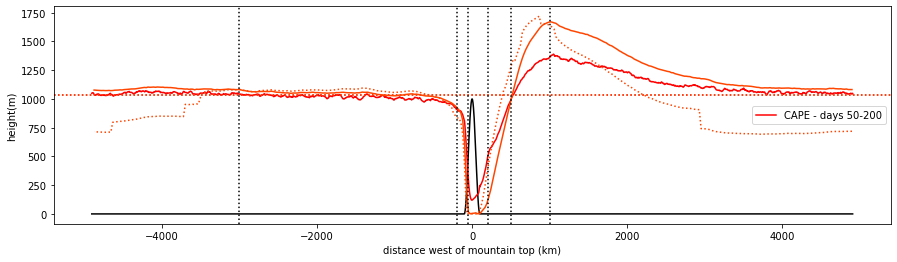

In [170]:
fig, ax = plt.subplots(1,1,figsize=(15,4))
ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("height(m)")
dist=(1635-hgt.west_east)*3

ax.plot(dist,hgt,color='k')
ax.plot(dist ,hrchannel_capecin[0].isel(Time=slice(200,800)).mean(['south_north','Time']),label='CAPE - days 50-200',color='r')
ax.legend(loc="center right")
ax.axhline(hrchannel_capecin[0].isel(Time=slice(200,800),west_east=slice(2000,3000)).mean(),color='r',linestyle=':')

dist2=(1635//n-np.arange(3270//n))*3*n
ax.plot(dist2 ,cape_fromskewt,color='orangered', label='CAPE from mean T&q')
ax.plot(dist2 ,cape_fromskewt_q,color='orangered',linestyle=':', label='CAPE from mean T&q, starting from 950hPa')
ax.axhline(np.mean(cape_fromskewt_q[2000//n:3000//n]),color='orangered',linestyle=':')

#ax.plot(dist2 ,cape_fromskewt925,color='orangered',linestyle='--', label='CAPE from mean T&q, starting from 925hPa')


for d in [-3000,-200,-50,200,500,1000]:
    ax.axvline(d,color='k',linestyle=':')

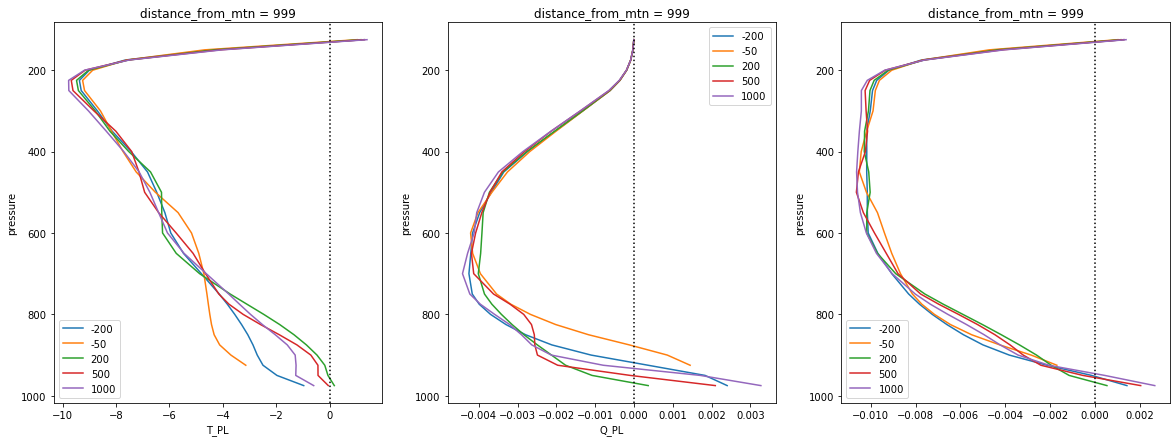

In [257]:
_,ax=plt.subplots(1,3,figsize=(20,7))

def moist_adiabat(p,SST):
    ma = mpcalc.moist_lapse(np.arange(1000,100,-5) * units.hPa,SST*units.degK)/units.degK
    tref = np.interp(np.array(p)[::-1],np.arange(1000,100,-5)[::-1],np.array(ma)[::-1])[::-1]
    qref = 0.7*np.array(mpcalc.saturation_mixing_ratio(p * units.hPa,tref*units.degK))
    return tref,qref
tref,qref = moist_adiabat(np.array(tmean_p.pressure),299)

for i,(d1,d2) in enumerate(zip([-3000]*5,[-200,-50,200,500,1000])):
    deltaT = (tmean_p.sel(distance_from_mtn=d2,method='nearest')-tref)
    deltaq = (qmean_p.sel(distance_from_mtn=d2,method='nearest')-qref)
    deltaT.plot(ax=ax[0],y='pressure',yincrease=False,label=d2)
    deltaq.plot(ax=ax[1],y='pressure',yincrease=False,label=d2)
    ((deltaq+deltaT/1000)).plot(ax=ax[2],y='pressure',yincrease=False,label=d2)

for a in ax:
    a.legend()
    a.axvline(0.,color='k',linestyle=':')
#ax[2].set_xlim(-2e3,2e3)